In [1]:
# IMPORTS

import os
import cv2
import time
# import tqdm
import keras
import shutil
# import tarfile 
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from keras.models import Model, Sequential
from keras.utils import to_categorical, np_utils
from keras.losses import mse, binary_crossentropy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import (LSTM, RepeatVector, Input, Dense, InputLayer, Flatten, Reshape, 
     Lambda, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, BatchNormalization)

# import warnings
# warnings.filterwarnings("ignore")

In [2]:
# MNIST DATASET

(x_train, y_train), (x_test, y_test) = mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

img_shape=x_train.shape[1:]

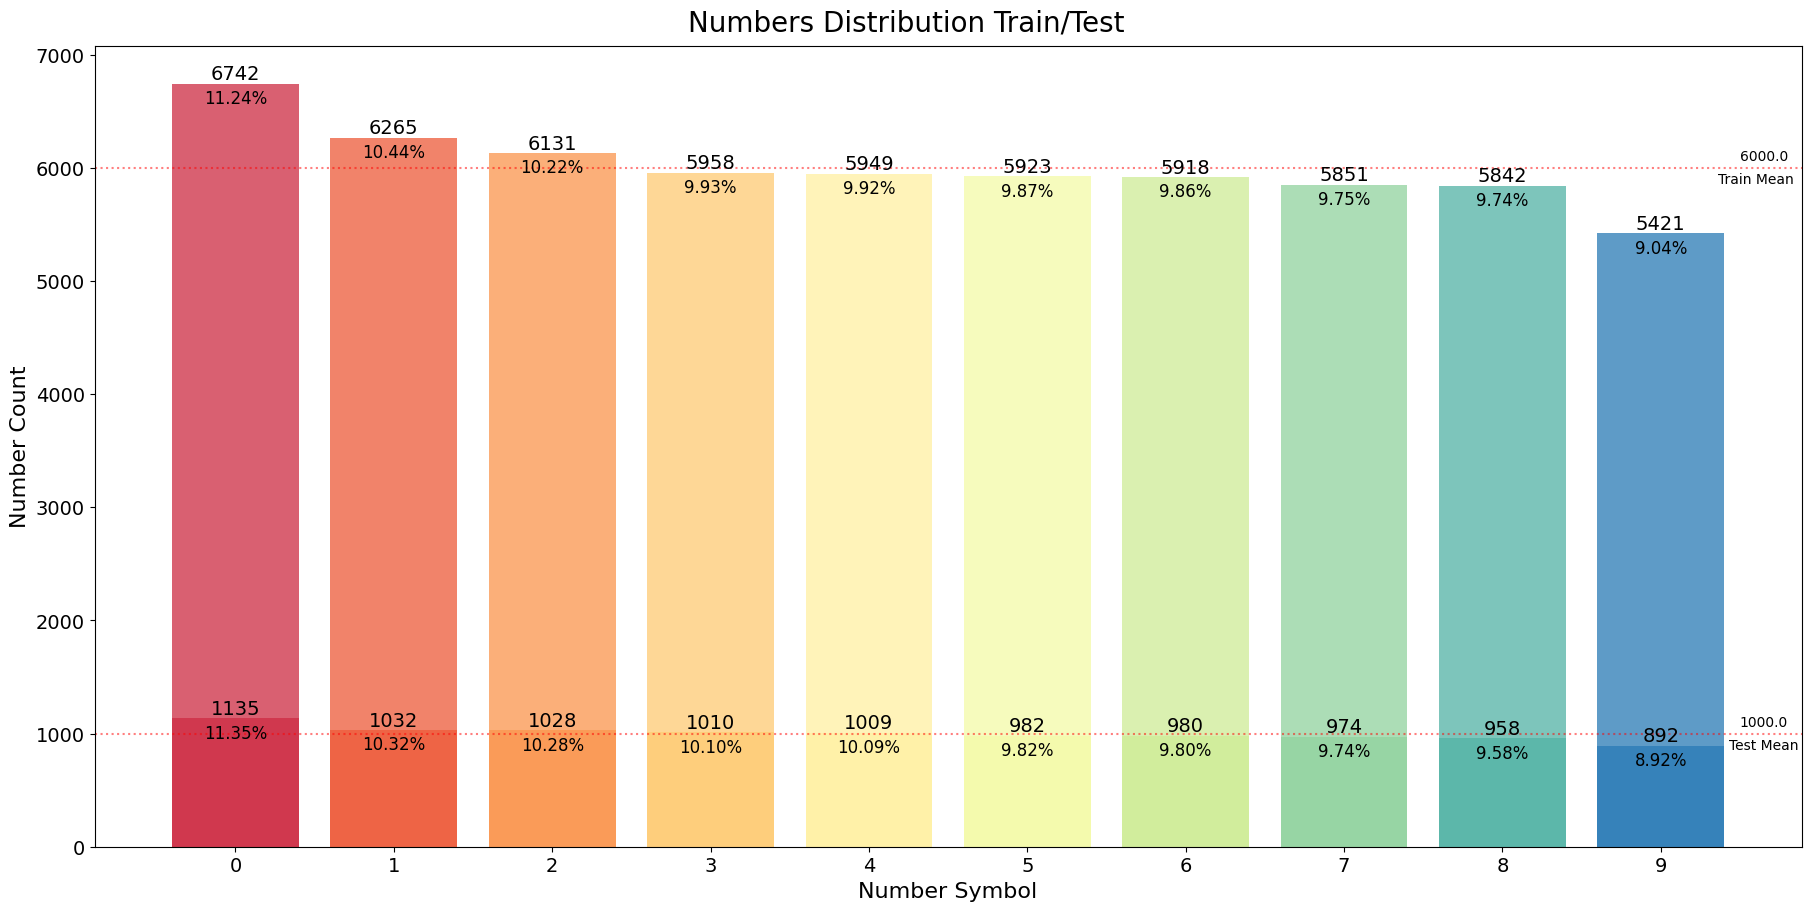

In [3]:
# VISUALIZATION OF NUMBER DISTRIBUTION

train = pd.DataFrame({'Train': y_train})
test = pd.DataFrame({'Test': y_test})
train_counts = train['Train'].value_counts()
test_counts = test['Test'].value_counts()
unique_train = train['Train'].unique()
unique_test = test['Test'].unique()
unique_train.sort()
unique_test.sort()

rainbow = sns.color_palette('Spectral', 10)
hex_values = [sns.mpl.colors.rgb2hex(color) for color in rainbow]

fig, axs = plt.subplots(figsize=(18, 9), layout='constrained')
fig.suptitle('Numbers Distribution Train/Test', fontsize=20)
plt.bar(unique_train, train_counts, color=hex_values, alpha=0.8)
plt.xticks(unique_train, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Number Symbol', fontsize=16)
plt.ylabel('Number Count', fontsize=16)

train_mean = np.mean(train_counts)
test_mean = np.mean(test_counts)
plt.axhline(train_mean, color='red', linestyle=':', label='Train Mean', alpha=0.5)
plt.text(9.5, train_mean+100, str(train_mean), ha='left', va='center')
plt.text(9.6, train_mean-100, 'Train Mean', ha='center', va='center')
plt.axhline(test_mean, color='red', linestyle=':', label='Test Mean', alpha=0.5)
plt.text(9.5, test_mean+100, str(test_mean), ha='left', va='center')
plt.text(9.65, test_mean-100, 'Test Mean', ha='center', va='center')

for i, v in enumerate(train_counts):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=14)
    plt.text(i, v-50, f'{v/60000:.2%}', ha='center', va='top', fontsize=12)

plt.bar(unique_test, test_counts, color=hex_values)
for i, v in enumerate(test_counts):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=14)
    plt.text(i, v-50, f'{v/10000:.2%}', ha='center', va='top', fontsize=12)

plt.show()

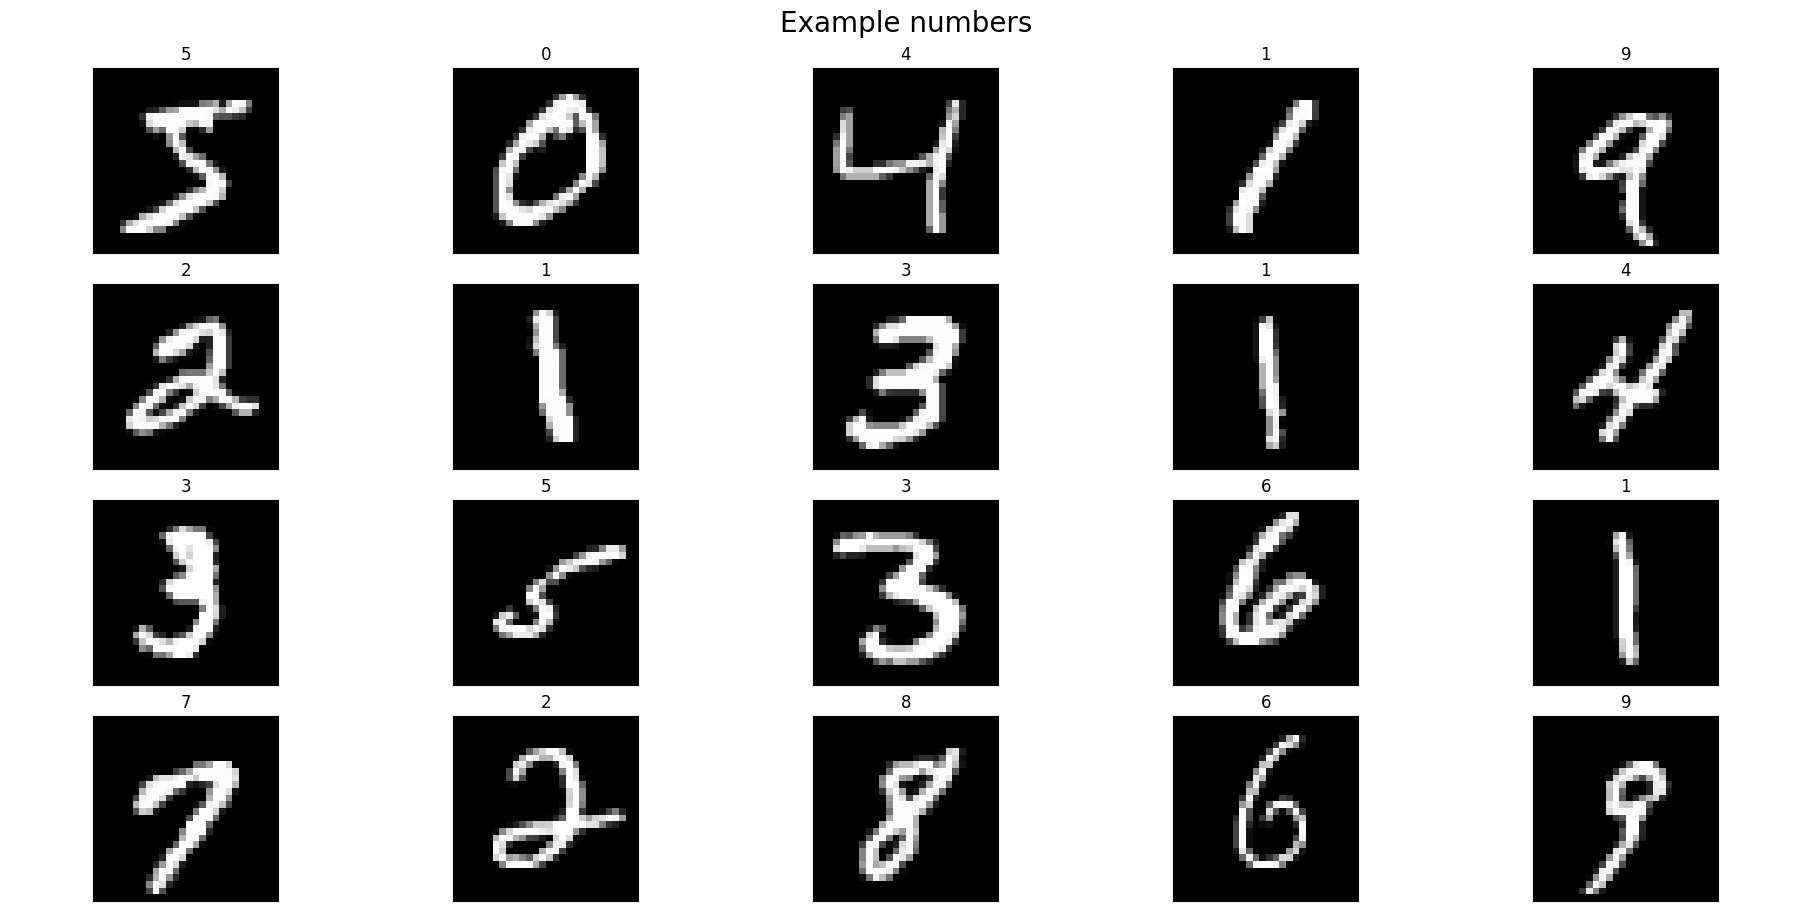

In [4]:
# SHOW EXAMPLE NUMBERS

fig, ax = plt.subplots(figsize=(18, 9), layout='constrained')
fig.suptitle('Example numbers', size=20)
plt.axis('off')
for i in range(20):
    fig.add_subplot(4, 5, i+1, xticks=[], yticks=[], title=y_train[i])
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')

In [5]:
# BASIC AUTOENCODER

def build_autoencoder(latent_dim, shape=img_shape):
    inputs = Input(shape, name='Input')
    code = Dense(latent_dim, activation='relu', name='Encoder')(inputs)
    outputs = Dense(shape[0], activation='sigmoid', name='Output')(code)

    autoencoder = Model(inputs, outputs, name=f'Autoencoder_{latent_dim}')
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

In [6]:
# FUNCTION FOR TRAINING AUTOENCODER OR LOADING EXISTING ONE

def get_autoencoder(dim, dir):
    model = None
    try:
        model = keras.models.load_model(f'{dir}/Autoencoder_{dim}.keras')
        print(f'\n<<< Loading saved autoencoder with {dim} dimensions... >>>')
        return model
    except:
        model = build_autoencoder(dim)
        print(f'\n<<< Creating new autoencoder with {dim} dimensions... >>>')
        return model

def fit_autoencoder(dim, epochs=20, batch_size=32, dir='MNIST', load=False):
    models_dir = f'./Models/{dir}'
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    autoencoder = get_autoencoder(dim, models_dir)
    autoencoder.summary()

    callbacks = [ModelCheckpoint(filepath=f'{models_dir}/Checkpoints_{autoencoder.name}/' + 'Checkpoint_{epoch}_{loss}.keras',
                                 save_best_only=True, monitor='val_loss', verbose=1),
                 EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)]

    if load:
        return autoencoder    
    
    autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=callbacks) # x_test, x_test
    autoencoder.save(f'{models_dir}/Autoencoder_{dim}.keras')
    shutil.rmtree(f'{models_dir}/Checkpoints_{autoencoder.name}/')
    
    return autoencoder

In [5]:
# TRAINING ALL AUTOENCODERS (2,4,8,16,32,64,128,256)

autoencoders = {}
autoencoder_times = {}
for key in (2, 4, 8, 16, 32, 64, 128, 256):
    start_time = time.time()
    autoencoders[key] = fit_autoencoder(key)
    end_time = time.time()
    autoencoder_times[key] = end_time - start_time


<<< Creating new autoencoder with 2 dimensions... >>>
Model: "Autoencoder_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 784)]             0         
                                                                 
 Encoder (Dense)             (None, 2)                 1570      
                                                                 
 Output (Dense)              (None, 784)               2352      
                                                                 
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1656/1688 [============================>.] - ETA: 0s - loss: 0.0706
Epoch 1: val_loss improved from inf to 0.06030, saving model to ./Models/MNIST/Checkpoints_Autoencoder_2\Checkpoint_1_0.07040826976299286.keras
1688/1688 [==========================

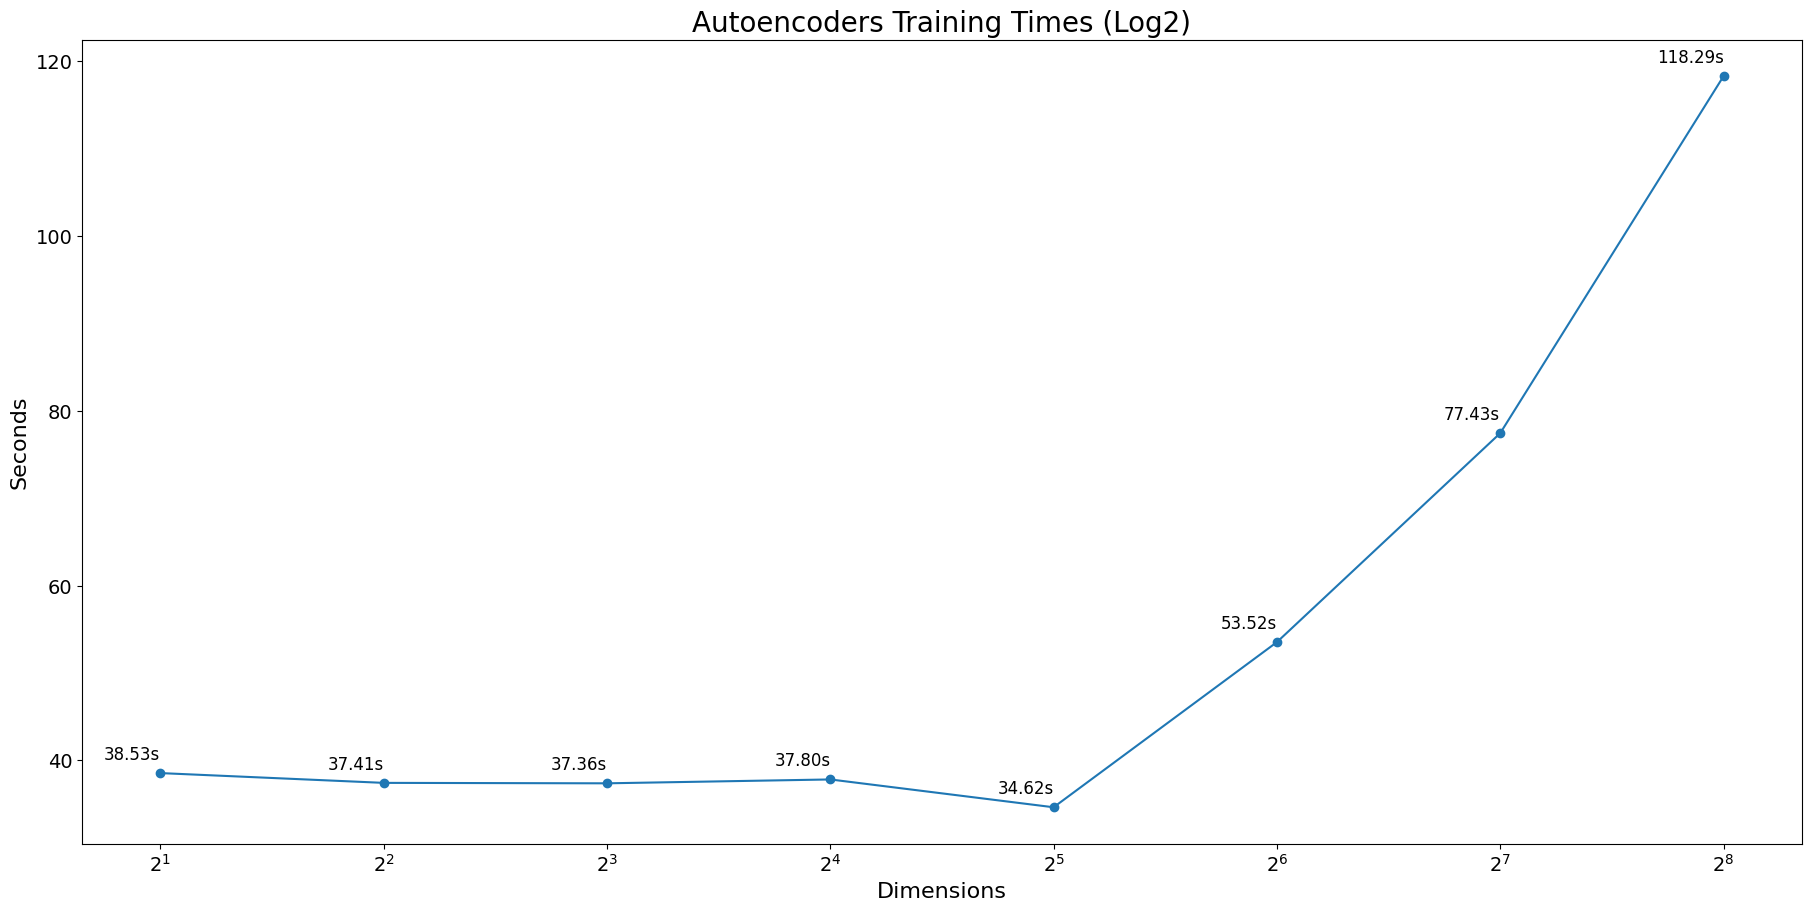

Time needed to train autoencoder with 2 dimentions: 38.53 seconds.
Time needed to train autoencoder with 4 dimentions: 37.41 seconds.
Time needed to train autoencoder with 8 dimentions: 37.36 seconds.
Time needed to train autoencoder with 16 dimentions: 37.80 seconds.
Time needed to train autoencoder with 32 dimentions: 34.62 seconds.
Time needed to train autoencoder with 64 dimentions: 53.52 seconds.
Time needed to train autoencoder with 128 dimentions: 77.43 seconds.
Time needed to train autoencoder with 256 dimentions: 118.29 seconds.


In [6]:
# TIME NEEDED TO TRAIN BASIC AUTOENCODERS

keys = list(autoencoder_times)
values = list(autoencoder_times.values())
fig, ax = plt.subplots(figsize=(18, 9), layout='constrained')
plt.plot(keys, values)
plt.scatter(keys, values)
plt.xlabel('Dimensions', fontsize=16)
plt.ylabel('Seconds', fontsize=16)
plt.xticks(keys, fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log', base=2)
plt.title('Autoencoders Training Times (Log2)', fontsize=20)

for i in range(len(keys)):
    plt.annotate(f'{values[i]:.2f}s', (keys[i], values[i]), textcoords="offset points", xytext=(0, 10), ha='right', fontsize=12)

plt.show()

for k, v in autoencoder_times.items():
    print(f'Time needed to train autoencoder with {k} dimentions: {v:.2f} seconds.')

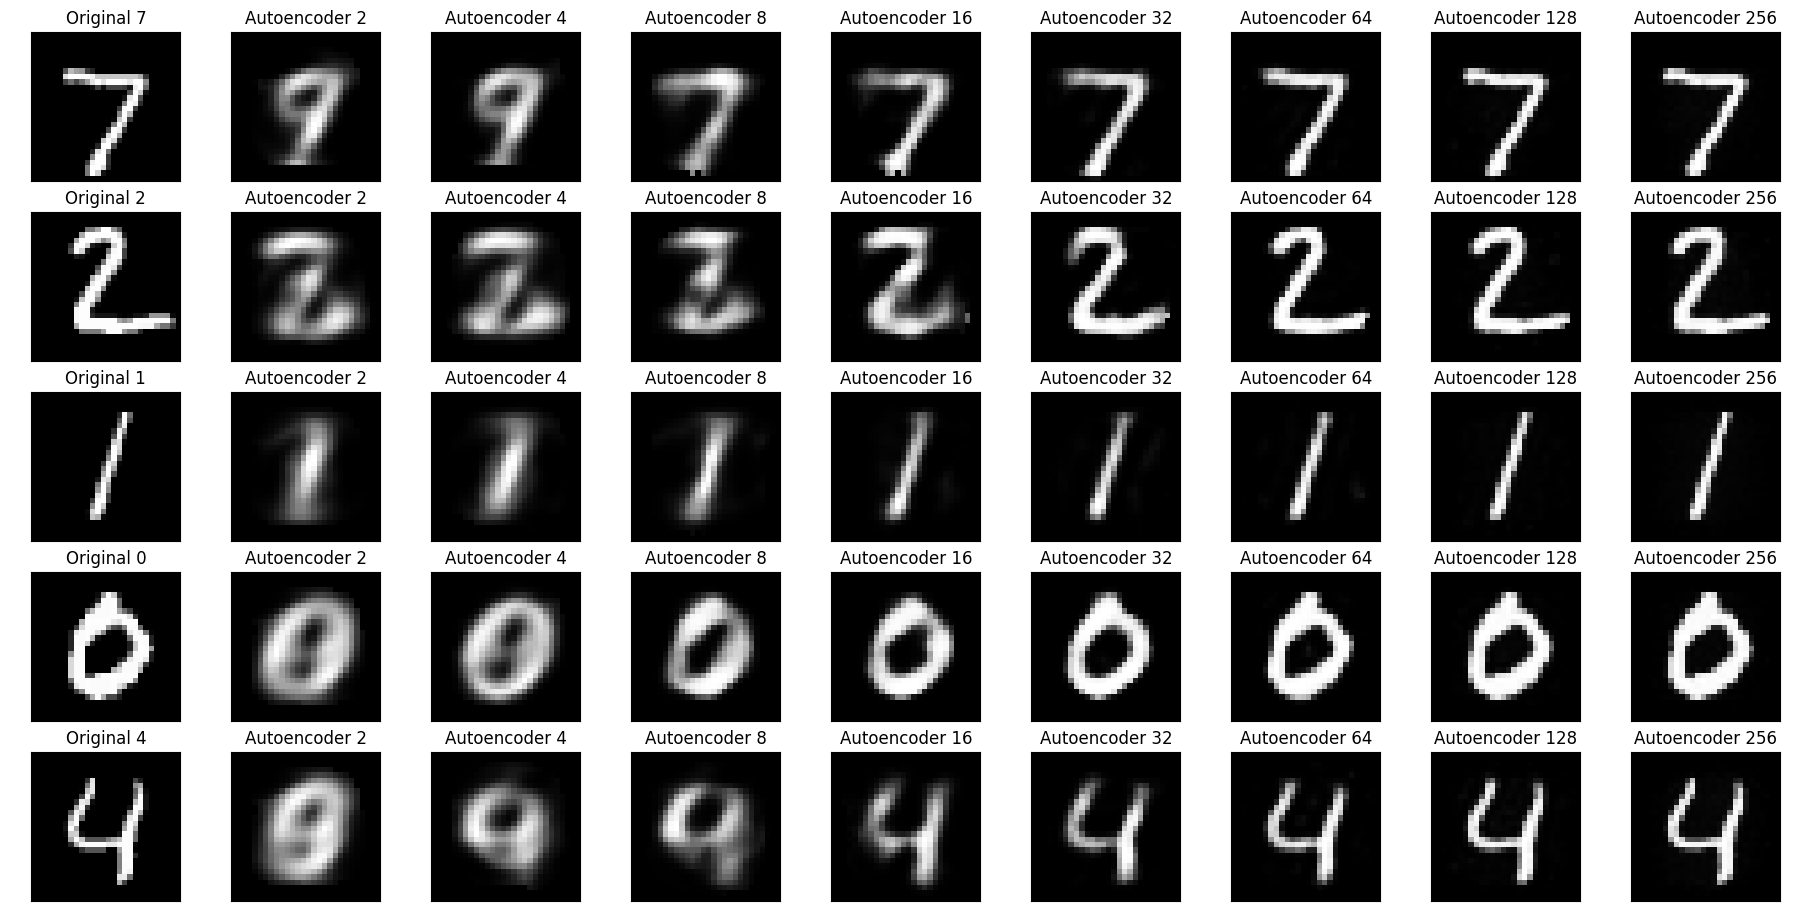

In [10]:
# RECONSTRUCTING IMAGES FROM AUTOENCODERS

fig, ax = plt.subplots(figsize=(18, 9), layout='constrained')
plt.axis('off')

predictions = {}
for k, v in autoencoders.items():
    predictions[k] = v.predict(x_test[0:5], verbose=0)

index = 1
for i in range(5):
    fig.add_subplot(5, len(autoencoders)+1, index, xticks=[], yticks=[]) #i*(len(autoencoders)+1)+1
    index += 1
    plt.title(f'Original {y_test[i]}')
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    for k, v in autoencoders.items():
        fig.add_subplot(5, len(autoencoders)+1, index, xticks=[], yticks=[]) #i*(len(autoencoders)+1)+j+2
        index += 1
        plt.title(f'Autoencoder {k}')
        plt.imshow(predictions[k][i].reshape(28, 28), cmap='gray')

In [8]:
# FUNCTION TO TEST MODELS BEFORE AND AFTER AUTOENCODERS

def test_model(dim, x_train=x_train, x_test=x_test, verbose=0):
    inputs = Input(dim)
    x = Flatten()(inputs)
    x = Dense(800, activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    model.fit(x_train, y_train, epochs=10, validation_split=0.1, verbose=verbose*1)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=verbose*2)
        
    return test_acc

In [9]:
# TESTING ALL AUTOENCODER ACCURACIES AND COMPARING THEM WITH THE BASE ONE

test_accs = {}
test_times = {}
base_mnist = 0

base_start_time = time.time()
for i in range(5):
    base_mnist += test_model(784)
base_end_time = time.time()

base_mnist /= 5.
base_time = (base_end_time - base_start_time) / 5.
print(f'<<< Base accuracy for MNIST dataset (784 dimensions): {base_mnist:.2%}. Average time needed for training: {base_time:.2f} seconds. >>>\n')

for dim, autoencoder in autoencoders.items():
    encoder = Model(autoencoder.inputs, autoencoder.get_layer('Encoder').output)
    new_train = encoder.predict(x_train, verbose=0)
    new_test = encoder.predict(x_test, verbose=0)
    acc = 0
    test_start_time = time.time()
    for i in range(5):
        acc += test_model(dim, new_train, new_test)
    test_end_time = time.time()
    test_accs[dim] = acc / 5.
    test_times[dim] = (test_end_time - test_start_time) / 5.
    print(f'Test accuracy for dim {dim}: {test_accs[dim]:.2%}. Average time needed for training: {test_times[dim]:.2f} seconds.')

print(f'\n<<< Best accuracy: {max(test_accs.values()):.2%} for {max(test_accs, key=test_accs.get)} dimensions. >>>')
print(f'<<< Best time: {min(test_times.values()):.2f}s for {min(test_times, key=test_times.get)} dimensions. >>>')

<<< Base accuracy for MNIST dataset (784 dimensions): 97.97%. Average time needed for training: 113.72 seconds. >>>

Test accuracy for dim 2: 44.45%. Average time needed for training: 15.64 seconds.
Test accuracy for dim 4: 67.02%. Average time needed for training: 15.86 seconds.
Test accuracy for dim 8: 89.71%. Average time needed for training: 17.37 seconds.
Test accuracy for dim 16: 96.24%. Average time needed for training: 16.89 seconds.
Test accuracy for dim 32: 97.54%. Average time needed for training: 18.09 seconds.
Test accuracy for dim 64: 97.58%. Average time needed for training: 20.17 seconds.
Test accuracy for dim 128: 97.25%. Average time needed for training: 25.53 seconds.
Test accuracy for dim 256: 97.34%. Average time needed for training: 34.52 seconds.

<<< Best accuracy: 97.58% for 64 dimensions. >>>
<<< Best time: 15.64s for 2 dimensions. >>>


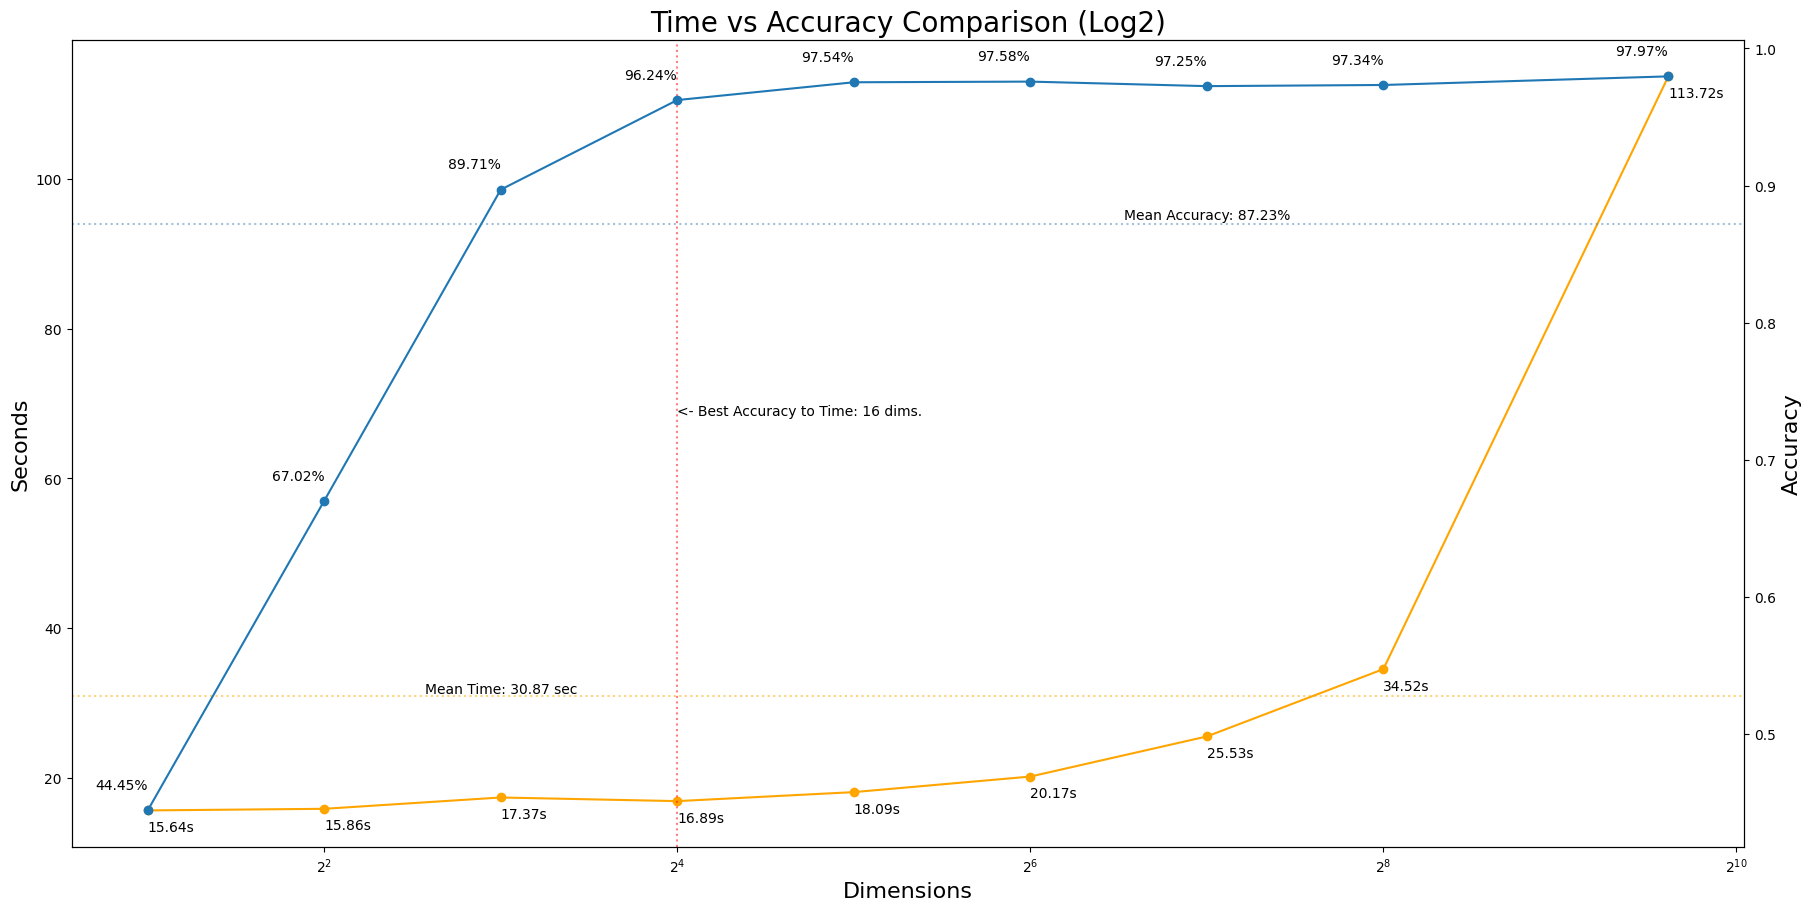

<<< Best accuracy compared to time is for 16 dimensions. >>>


In [13]:
time_keys = list(test_times)
time_values = list(test_times.values())
time_keys.append(784)
time_values.append(base_time) 

acc_keys = list(test_accs)
acc_values = list(test_accs.values())
acc_keys.append(784)
acc_values.append(base_mnist)

mean_time = np.mean(time_values)
mean_acc = np.mean(acc_values)

fig, ax = plt.subplots(figsize=(18, 9), layout='constrained')
plt.title('Time vs Accuracy Comparison (Log2)', fontsize=20)
ax.plot(time_keys, time_values, marker='o', color='orange')

ax.set_xlabel('Dimensions', fontsize=16)
ax.set_ylabel('Seconds', fontsize=16)
ax.set_xscale('log', base=2)

ax2 = ax.twinx()
ax2.plot(acc_keys, acc_values, marker='o')
ax2.set_ylabel('Accuracy', fontsize=16)

for i in range(len(time_keys)):
    ax.annotate(f'{time_values[i]:.2f}s', (time_keys[i], time_values[i]), textcoords="offset points", xytext=(0, -15), ha='left')
    ax2.annotate(f'{acc_values[i]:.2%}', (acc_keys[i], acc_values[i]), textcoords='offset points', xytext=(0, 15), ha='right')

ax.axhline(mean_time, color='orange', linestyle=':', label='Mean Time', alpha=0.5)
ax.text(8, mean_time*1.001, f'Mean Time: {mean_time:.2f} sec', ha='center', va='bottom')
ax2.axhline(mean_acc, color='steelblue', linestyle=':', label='Mean Acc', alpha=0.5)
ax2.text(128, mean_acc*1.001, f'Mean Accuracy: {mean_acc:.2%}', ha='center', va='bottom')

worth = np.divide(acc_values, time_values)
best_dim = time_keys[np.argmax(worth)]

ax.axvline(best_dim, color='red', linestyle=':', label='Highest Value', alpha=0.5)
ax.text(best_dim, 69, f'<- Best Accuracy to Time: {best_dim} dims.', ha='left', va='center') 

plt.show()

print(f'<<< Best accuracy compared to time is for {best_dim} dimensions. >>>')

In [14]:
# FIT OTHER AUTOENCODER MODELS

def build_model(name):
    if name == 'Deep':
        return get_deep_autoencoder()
    elif name == 'Deeper':
        return get_deeper_autoencoder()
    elif name == 'Sparse':
        return get_sparse_autoencoder()
    elif name == 'Denoising':
        return get_denoising_autoencoder()
    elif name == 'Variational':
        return get_variational_autoencoder()
    elif name == 'Convolutional':
        return get_convolutional_autoencoder()
    else:
        print(f'<<< There is no autoencoder with the name: {name} >>>')
        return None

def get_model(name, dir):
    model = None
    try:
        model = keras.models.load_model(f'{dir}/{name}.keras')
        print(f'\n<<< Loading saved {name} autoencoder... >>>\n')
        return model
    except:
        model = build_model(name)
        print(f'\n<<< Creating new {name} autoencoder... >>>\n')
        return model

def fit_model(name, epochs=10, batch_size=32, load=False, dir='MNIST'):
    models_dir = f'./Models/{dir}'
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    autoencoder = get_model(name, models_dir)
    autoencoder.summary()

    callbacks = [ModelCheckpoint(filepath=f'{models_dir}/Checkpoints_{autoencoder.name}/' + 'Checkpoint_{epoch}_{loss}.keras',
                                 save_best_only=True, monitor='val_loss', verbose=1),
                 EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)]

    if load:
        return autoencoder
    
    if name in ['Deep', 'Deeper', 'Sparse']:
        autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=callbacks)
    elif name == 'Denoising':
        noise_factor = 0.4
        x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
        x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
        autoencoder.fit(x_train_noisy, x_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=callbacks)    
    elif name == 'Variational':
        autoencoder.fit(x_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=callbacks) 
    elif name == 'Convolutional':
        x_train_new = np.reshape(x_train, (len(x_train), 28, 28, 1))
        autoencoder.fit(x_train_new, x_train_new, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=callbacks)

    autoencoder.save(f'{models_dir}/{autoencoder.name}.keras')
    shutil.rmtree(f'{models_dir}/Checkpoints_{autoencoder.name}/')
    
    return autoencoder

In [7]:
# DEEP AUTOENCODER

def get_deep_autoencoder():
    inputs = Input(shape=img_shape, name='Input')
    x = Dense(256, activation='relu')(inputs)
    x = Dense(latent_dim, activation='relu', name='Encoder')(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(img_shape[0], activation='sigmoid', name='Output')(x)

    deep_ae = Model(inputs, outputs, name='Deep')
    deep_ae.compile(optimizer='adam', loss='mse')
    return deep_ae

In [8]:
# DEEPER AUTOENCODER

def get_deeper_autoencoder():    
    inputs = Input(shape=img_shape, name='Input')
    x = Dense(256, activation='relu')(inputs)
    x = Dense(128, activation='relu')(x)
    x = Dense(latent_dim, activation='relu', name='Encoder')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(img_shape[0], activation='sigmoid', name='Output')(x)
    
    deeper_ae = Model(inputs, outputs, name='Deeper')
    deeper_ae.compile(optimizer='adam', loss='mse')
    return deeper_ae

In [9]:
# SPARSE AUTOENCODER

def get_sparse_autoencoder():    
    inputs = Input(shape=img_shape, name='Input')
    x = Dense(256, activation='relu')(inputs)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(latent_dim, activity_regularizer=l1(10e-5), activation='relu', name='Encoder')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(img_shape[0], activation='sigmoid', name='Output')(x)
    
    sparse_ae = Model(inputs, outputs, name='Sparse')
    sparse_ae.compile(optimizer='adam', loss='mse')
    return sparse_ae

In [18]:
# DENOISING AUTOENCODER

def get_denoising_autoencoder():
    inputs = Input(shape=img_shape, name='Input')
    encoded = Dense(256, activation='relu')(inputs)
    code = Dense(latent_dim, activation='relu', name='Encoder')(encoded)
    decoded = Dense(256, activation='relu')(code)
    outputs = Dense(img_shape[0], activation='sigmoid', name='Output')(decoded)
    
    denoising_ae = Model(inputs, outputs, name='Denoising')
    denoising_ae.compile(optimizer=Adam(learning_rate=0.001), loss=mse)
    return denoising_ae

In [19]:
# VARIATIONAL AUTOENCODER

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def get_variational_autoencoder():
    inputs = Input(shape=img_shape, name='Input')
    hidden_enc = Dense(256, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(hidden_enc)
    z_log_var = Dense(latent_dim)(hidden_enc)
    
    z = Lambda(sampling, name='Encoder')([z_mean, z_log_var])
    
    hidden_dec = Dense(256, activation='relu')(z)
    outputs = Dense(img_shape[0], activation='sigmoid', name='Output')(hidden_dec)
    
    reconstruction_loss = K.sum(K.binary_crossentropy(inputs, outputs), axis=-1)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)

    variational_ae = Model(inputs, outputs, name='Variational')   
    variational_ae.add_loss(vae_loss)
    variational_ae.compile(optimizer='adam')
    return variational_ae

In [33]:
# CONVOLUTIONAL AUTOENCODER

def get_convolutional_autoencoder(input_shape=(28, 28, 1)):    
    inputs = Input(shape=input_shape, name='Input')
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same', name='Encoder')(x)
    x = Flatten()(x)
    encoded = Dense(32)(x)

    x = Dense(392)(encoded)
    x = Reshape((7, 7, 8))(x)
    x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    outputs = Conv2DTranspose(input_shape[2], (3, 3), activation='sigmoid', padding='same', name='Output')(x)
    
    convolutional_ae = Model(inputs, outputs, name='Convolutional')
    convolutional_ae.compile(optimizer='adam', loss='binary_crossentropy')
    return convolutional_ae

In [21]:
# FIT AUTOENCODERS
latent_dim = 32 # best_dim

adv_autoencoders = {}
adv_autoencoder_times = {}
adv_autoencoder_names = ['Deep', 'Deeper', 'Sparse', 'Denoising', 'Variational', 'Convolutional']
for ae in adv_autoencoder_names:
    start_time = time.time()
    adv_autoencoders[ae] = fit_model(ae)
    end_time = time.time()
    adv_autoencoder_times[ae] = end_time - start_time


<<< Creating new Deep autoencoder... >>>

Model: "Deep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 784)]             0         
                                                                 
 dense_78 (Dense)            (None, 256)               200960    
                                                                 
 Encoder (Dense)             (None, 32)                8224      
                                                                 
 dense_79 (Dense)            (None, 256)               8448      
                                                                 
 Output (Dense)              (None, 784)               201488    
                                                                 
Total params: 419,120
Trainable params: 419,120
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
16

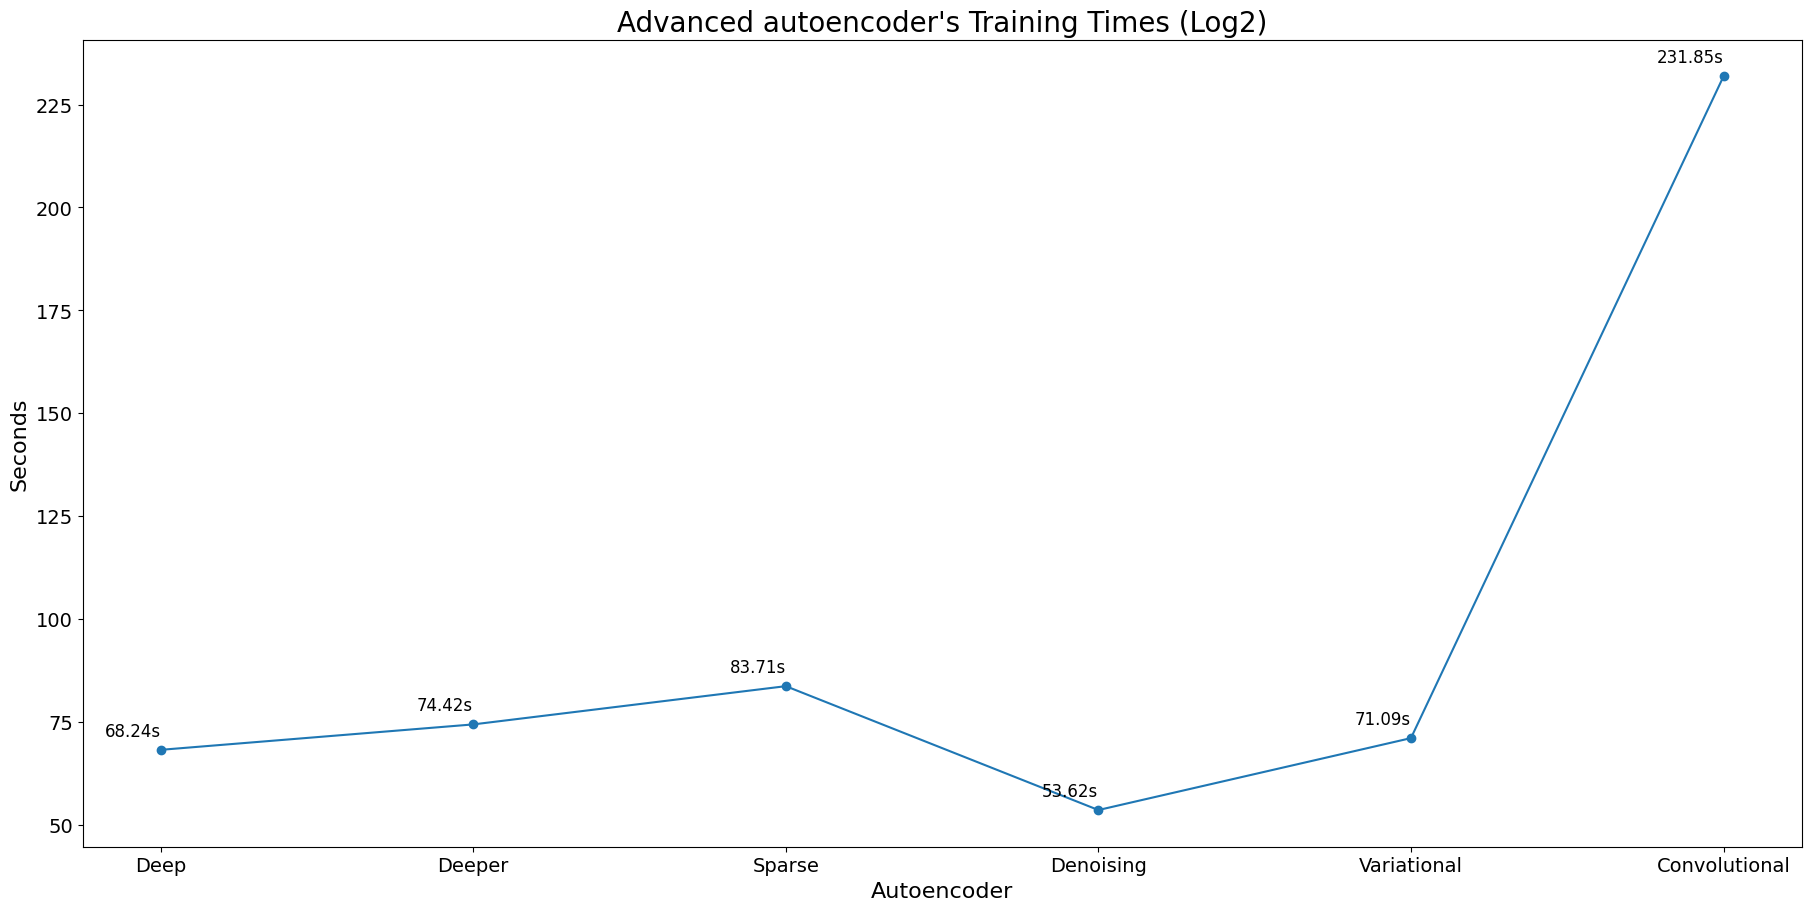

Time needed to train Deep autoencoder: 68.24 seconds.
Time needed to train Deeper autoencoder: 74.42 seconds.
Time needed to train Sparse autoencoder: 83.71 seconds.
Time needed to train Denoising autoencoder: 53.62 seconds.
Time needed to train Variational autoencoder: 71.09 seconds.
Time needed to train Convolutional autoencoder: 231.85 seconds.


In [22]:
# TIME NEEDED TO TRAIN ADVANCED AUTOENCODERS

keys = list(adv_autoencoder_times)
values = list(adv_autoencoder_times.values())
fig, ax = plt.subplots(figsize=(18, 9), layout='constrained')
plt.plot(keys, values, marker='o')
plt.xlabel('Autoencoder', fontsize=16)
plt.ylabel('Seconds', fontsize=16)
plt.xticks(keys, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Advanced autoencoder\'s Training Times (Log2)', fontsize=20)

for i in range(len(keys)):
    plt.annotate(f'{values[i]:.2f}s', (keys[i], values[i]), textcoords="offset points", xytext=(0, 10), ha='right', fontsize=12)

plt.show()

for k, v in adv_autoencoder_times.items():
    print(f'Time needed to train {k} autoencoder: {v:.2f} seconds.')

In [23]:
# AUTOENCODER PREDICTIONS

noise_factor = 0.4
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)
x_test_new = np.reshape(x_test, (len(x_test), 28, 28, 1))

adv_predictions = {}
for ae in adv_autoencoder_names:
    print(f'<<< {ae} AE predictions >>>')
    if ae == 'Denoising':
        adv_predictions[ae] = adv_autoencoders[ae].predict(x_test_noisy)
    elif ae == 'Convolutional':
        adv_predictions[ae] = adv_autoencoders[ae].predict(x_test_new)
    else:
        adv_predictions[ae] = adv_autoencoders[ae].predict(x_test)

<<< Deep AE predictions >>>
313/313 [==============================] - 0s 1ms/step
<<< Deeper AE predictions >>>
313/313 [==============================] - 1s 1ms/step
<<< Sparse AE predictions >>>
313/313 [==============================] - 1s 1ms/step
<<< Denoising AE predictions >>>
313/313 [==============================] - 0s 1ms/step
<<< Variational AE predictions >>>
313/313 [==============================] - 1s 1ms/step
<<< Convolutional AE predictions >>>
313/313 [==============================] - 2s 6ms/step


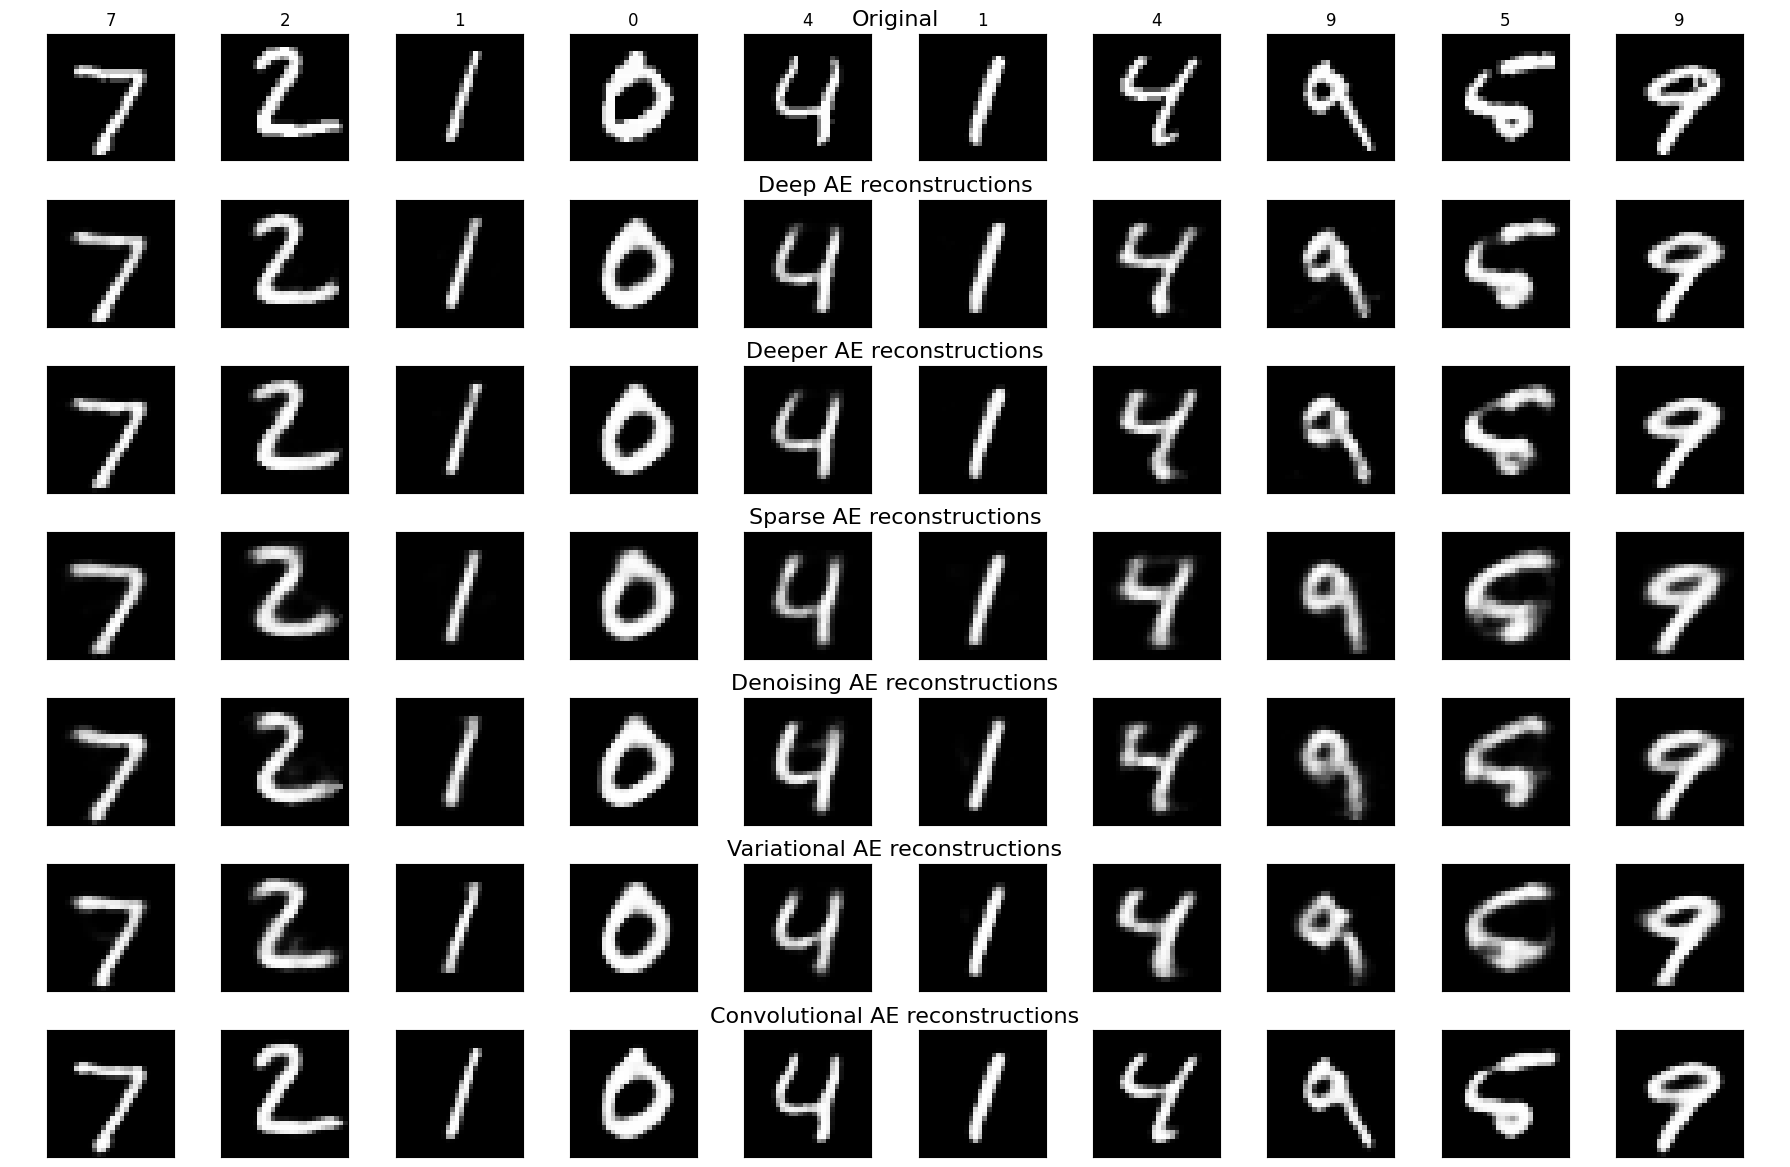

In [21]:
# SHOW ORIGINAL IMAGES AND RECONSTRUCTED WITH AUTOENCODERS

fig, axs = plt.subplots(figsize=(18, 12), layout='tight', nrows=7, ncols=1)
for ax in axs:
    ax.axis('off')

for i in range(10):
    axs[0].set_title('Original', fontsize=16)
    fig.add_subplot(7, 10, i+1, xticks=[], yticks=[], title=y_test[i])
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')

for i, ae in enumerate(adv_autoencoder_names):     
    for j in range(10):    
        axs[i+1].set_title(f'{ae} AE reconstructions', fontsize=16)
        fig.add_subplot(7, 10, j+1+(i+1)*10, xticks=[], yticks=[])
        plt.imshow(adv_predictions[ae][j].reshape(28, 28), cmap='gray')

In [26]:
# TESTING MODELS

test_accs_mnist = {}
test_times_mnist = {}
print(f'<<< Base accuracy for MNIST dataset (784 dimensions): {base_mnist:.2%}. Average time needed for training: {base_time:.2f} seconds. >>>\n')

for ae in adv_autoencoder_names:
    encoder = Model(adv_autoencoders[ae].inputs, adv_autoencoders[ae].get_layer('Encoder').output)
    acc = 0
    if ae == 'Convolutional': 
        new_train = encoder.predict(np.reshape(x_train, (len(x_train), 28, 28, 1)), verbose=0)
        new_test = encoder.predict(np.reshape(x_test, (len(x_test), 28, 28, 1)), verbose=0)
    else:
        new_train = encoder.predict(x_train, verbose=0)
        new_test = encoder.predict(x_test, verbose=0)
    test_start_time = time.time()
    for i in range(5):
        acc += test_model(latent_dim, new_train, new_test)
    test_end_time = time.time()
    test_accs_mnist[ae] = acc / 5.
    test_times_mnist[ae] = (test_end_time - test_start_time) / 5.
    print(f'Test accuracy for {ae} autoencoder: {test_accs_mnist[ae]:.2%}. Average time needed for training: {test_times_mnist[ae]:.2f} seconds.')

print(f'\n<<< Best accuracy: {max(test_accs_mnist.values()):.2%} for {max(test_accs_mnist, key=test_accs_mnist.get)} autoencoder >>>')
print(f'<<< Best time: {min(test_times_mnist.values()):.2f}s for {min(test_times_mnist, key=test_times_mnist.get)} autoencoder. >>>')

<<< Base accuracy for MNIST dataset (784 dimensions): 97.97%. Average time needed for training: 113.72 seconds. >>>

Test accuracy for Deep autoencoder: 97.34%. Average time needed for training: 21.19 seconds.
Test accuracy for Deeper autoencoder: 97.60%. Average time needed for training: 20.88 seconds.
Test accuracy for Sparse autoencoder: 96.81%. Average time needed for training: 20.75 seconds.
Test accuracy for Denoising autoencoder: 97.23%. Average time needed for training: 20.91 seconds.
Test accuracy for Variational autoencoder: 95.82%. Average time needed for training: 21.05 seconds.
Test accuracy for Convolutional autoencoder: 98.44%. Average time needed for training: 20.99 seconds.

<<< Best accuracy: 98.44% for Convolutional autoencoder >>>
<<< Best time: 20.75s for Sparse autoencoder. >>>


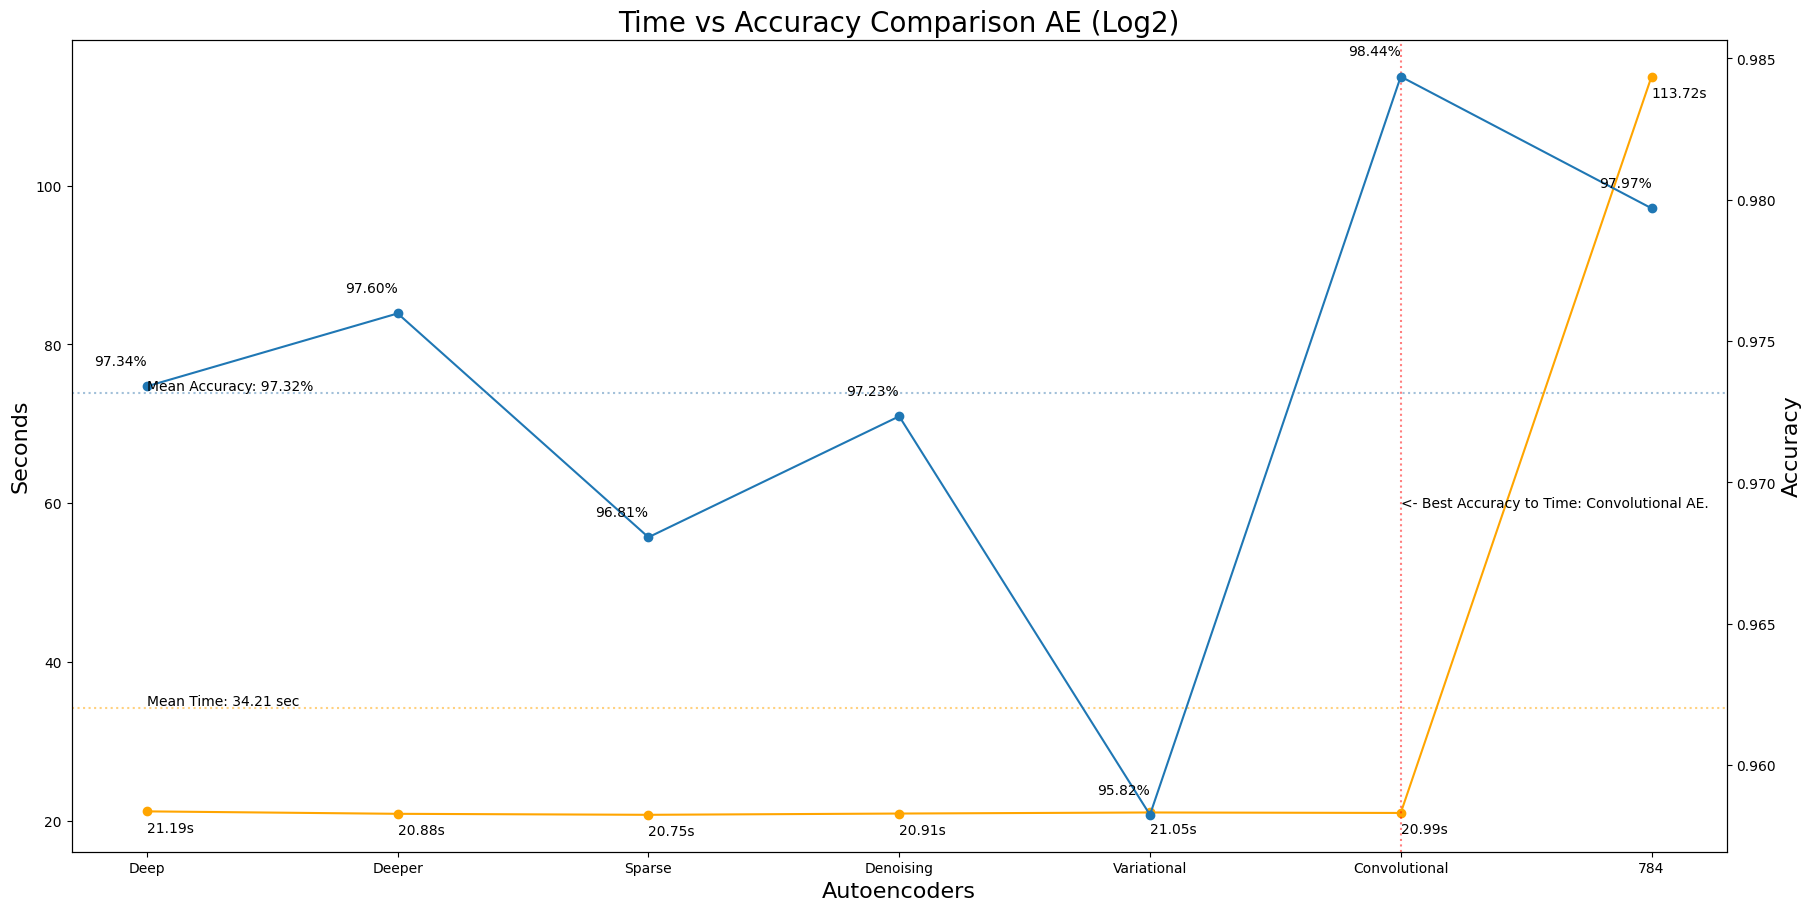

<<< Best accuracy compared to time is for Convolutional autoencoder. >>>


In [28]:
time_keys = list(test_times_mnist)
time_values = list(test_times_mnist.values())
time_keys.append('784')
time_values.append(base_time) 

acc_keys = list(test_accs_mnist)
acc_values = list(test_accs_mnist.values())
acc_keys.append('784')
acc_values.append(base_mnist)

mean_time = np.mean(time_values)
mean_acc = np.mean(acc_values)

fig, ax1 = plt.subplots(figsize=(18, 9), layout='constrained')
plt.title('Time vs Accuracy Comparison AE (Log2)', fontsize=20)
ax1.plot(time_keys, time_values, marker='o', color='orange')
ax1.set_xlabel('Autoencoders', fontsize=16)
ax1.set_ylabel('Seconds', fontsize=16)

ax2 = ax1.twinx()
ax2.plot(acc_keys, acc_values, marker='o')
ax2.set_ylabel('Accuracy', fontsize=16)

for i in range(len(time_keys)):
    ax1.annotate(f'{time_values[i]:.2f}s', (time_keys[i], time_values[i]), textcoords="offset points", xytext=(0, -15), ha='left')
    ax2.annotate(f'{acc_values[i]:.2%}', (acc_keys[i], acc_values[i]), textcoords='offset points', xytext=(0, 15), ha='right')

ax1.axhline(mean_time, color='orange', linestyle=':', label='Mean Time', alpha=0.5)
ax1.text(0, mean_time, f'Mean Time: {mean_time:.2f} sec', ha='left', va='bottom')
ax2.axhline(mean_acc, color='steelblue', linestyle=':', label='Mean Acc', alpha=0.5)
ax2.text(0, mean_acc, f'Mean Accuracy: {mean_acc:.2%}', ha='left', va='bottom')

worth = np.divide(acc_values, time_values)
best_ae = time_keys[np.argmax(worth)]

ax1.axvline(best_ae, color='red', linestyle=':', label='Highest Value', alpha=0.5)
ax1.text(best_ae, 60, f'<- Best Accuracy to Time: {best_ae} AE.', ha='left', va='center') 

plt.show()

print(f'<<< Best accuracy compared to time is for {best_ae} autoencoder. >>>')

In [30]:
data = {
    'BASE': [0, base_mnist, base_time, base_time],
    'BaseAE 2': [autoencoder_times[2], test_accs[2], test_times[2], autoencoder_times[2] + test_times[2]],
    'BaseAE 4': [autoencoder_times[4], test_accs[4], test_times[4], autoencoder_times[4] + test_times[4]],
    'BaseAE 8': [autoencoder_times[8], test_accs[8], test_times[8], autoencoder_times[8] + test_times[8]],
    'BaseAE 16': [autoencoder_times[16], test_accs[16], test_times[16], autoencoder_times[16] + test_times[16]],
    'BaseAE 32': [autoencoder_times[32], test_accs[32], test_times[32], autoencoder_times[32] + test_times[32]],
    'BaseAE 64': [autoencoder_times[64], test_accs[64], test_times[64], autoencoder_times[64] + test_times[64]],
    'BaseAE 128': [autoencoder_times[128], test_accs[128], test_times[128], autoencoder_times[128] + test_times[128]],
    'BaseAE 256': [autoencoder_times[256], test_accs[256], test_times[256], autoencoder_times[256] + test_times[256]],
    'Deep AE': [adv_autoencoder_times['Deep'], test_accs_mnist['Deep'], test_times_mnist['Deep'], adv_autoencoder_times['Deep'] + test_times_mnist['Deep']],
    'Deeper AE': [adv_autoencoder_times['Deeper'], test_accs_mnist['Deeper'], test_times_mnist['Deeper'], adv_autoencoder_times['Deeper'] + test_times_mnist['Deeper']],
    'Sparse AE': [adv_autoencoder_times['Sparse'], test_accs_mnist['Sparse'], test_times_mnist['Sparse'], adv_autoencoder_times['Sparse'] + test_times_mnist['Sparse']],
    'Denoising AE': [adv_autoencoder_times['Denoising'], test_accs_mnist['Denoising'], test_times_mnist['Denoising'], adv_autoencoder_times['Denoising'] + test_times_mnist['Denoising']],
    'Variational AE': [adv_autoencoder_times['Variational'], test_accs_mnist['Variational'], test_times_mnist['Variational'], adv_autoencoder_times['Variational'] + test_times_mnist['Variational']],
    'Convolutional AE': [adv_autoencoder_times['Convolutional'], test_accs_mnist['Convolutional'], test_times_mnist['Convolutional'], adv_autoencoder_times['Convolutional'] + test_times_mnist['Convolutional']]
}

df = pd.DataFrame(data=data, index=['Training Time (s)', 'Accuracy (%)', 'Test Time (s)', 'Total Time (s)'])
df = df.transpose()

df['Training Time (s)'] = df['Training Time (s)'].map("{:.2f}".format)
df['Accuracy (%)'] = df['Accuracy (%)'].map("{:.2%}".format)
df['Test Time (s)'] = df['Test Time (s)'].map("{:.2f}".format)
df['Total Time (s)'] = df['Total Time (s)'].map("{:.2f}".format)

df

Training Time (s) Accuracy (%) Test Time (s) Total Time (s)
BASE                          0.00       97.97%        113.72         113.72
BaseAE 2                     38.53       44.45%         15.64          54.17
BaseAE 4                     37.41       67.02%         15.86          53.27
BaseAE 8                     37.36       89.71%         17.37          54.73
BaseAE 16                    37.80       96.24%         16.89          54.69
BaseAE 32                    34.62       97.54%         18.09          52.71
BaseAE 64                    53.52       97.58%         20.17          73.69
BaseAE 128                   77.43       97.25%         25.53         102.96
BaseAE 256                  118.29       97.34%         34.52         152.81
Deep AE                      68.24       97.34%         21.19          89.43
Deeper AE                    74.42       97.60%         20.88          95.30
Sparse AE                    83.71       96.81%         20.75         104.46
Denoising AE                 53.62       97.23%         20.91          74.53
Variational AE               71.09       95.82%         21.05          92.14
Convolutional AE            231.85       98.44%         20.99         252.84

In [30]:
from sklearn.decomposition import PCA, FastICA, NMF, MiniBatchDictionaryLearning, TruncatedSVD
from sklearn.manifold import TSNE

# MNIST DATASET

(x_train, y_train), (x_test, y_test) = mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

img_shape=x_train.shape[1:]

fe_train_times = {}
fe_accs = {}
fe_times = {}

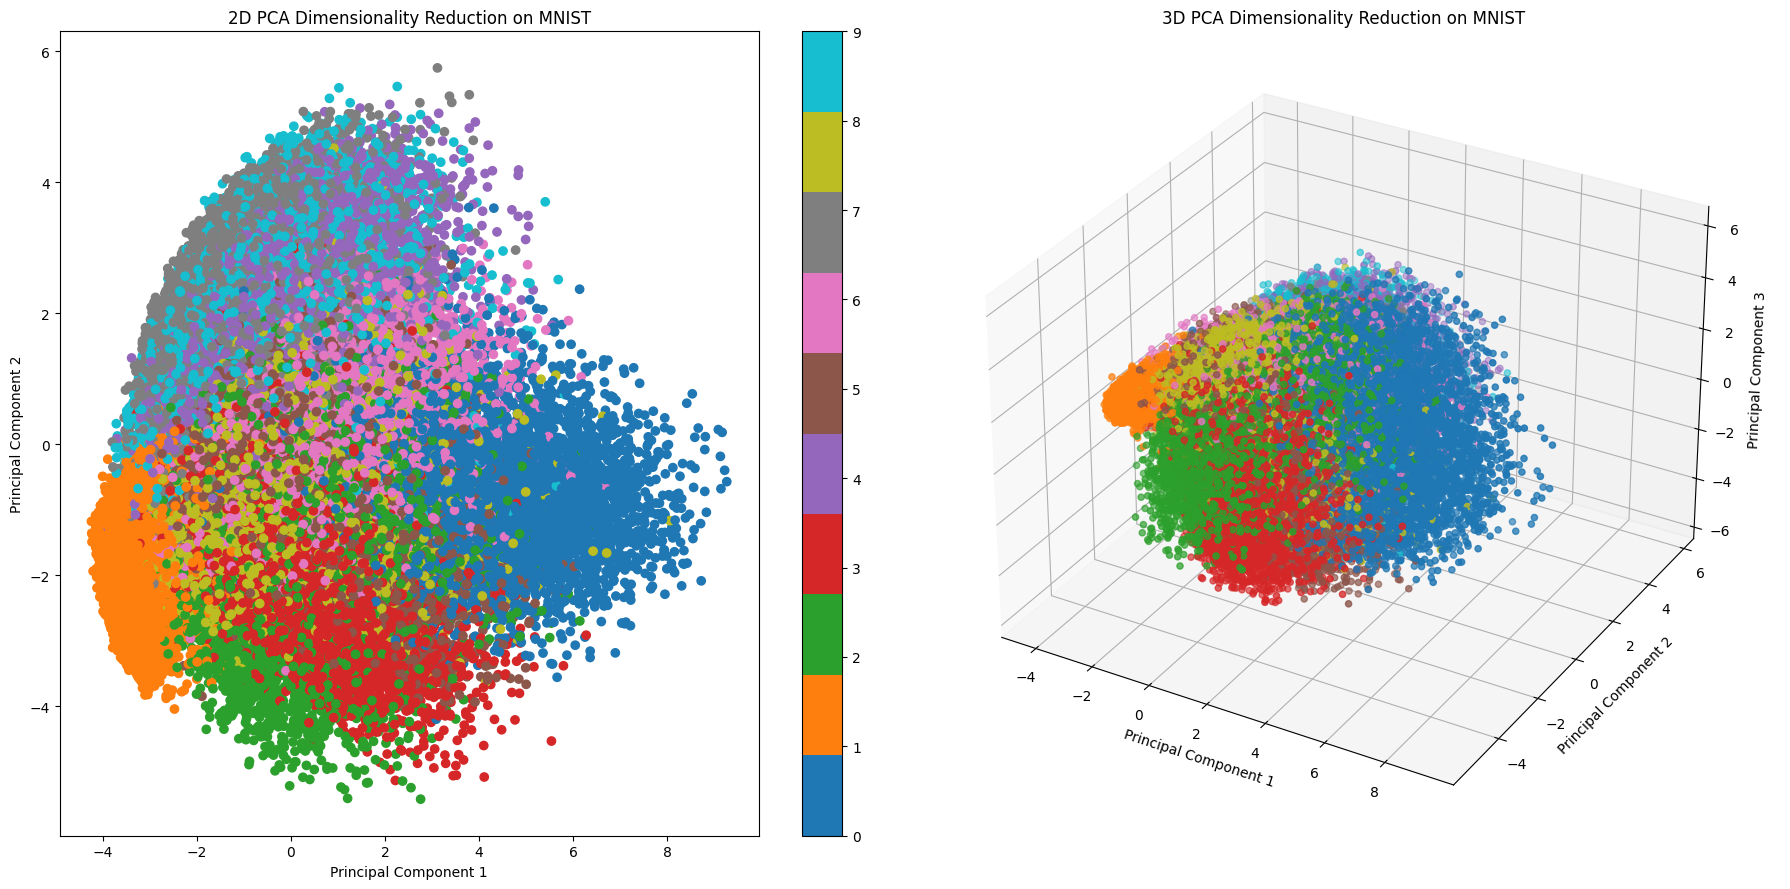

<<< Total preserved variance for 2D: 16.80%. Total preserved variance for 3D: 22.97% >>>


In [31]:
# 2D AND 3D VISUALIZATION USING PCA

start_time = time.time()
pca2 = PCA(2, random_state=42)
x_pca_train_2 = pca2.fit_transform(x_train)
x_pca_test_2 = pca2.transform(x_test)
end_time = time.time()
fe_train_times['PCA2'] = end_time - start_time

fig, ax = plt.subplots(figsize=(18, 9), layout='tight')
plt.axis('off')

ax1 = fig.add_subplot(1, 2, 1)
cb = ax1.scatter(x_pca_train_2[:, 0], x_pca_train_2[:, 1], c=y_train, cmap='tab10')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_title('2D PCA Dimensionality Reduction on MNIST')

plt.colorbar(cb)

start_time = time.time()
pca3 = PCA(3, random_state=42)
x_pca_train_3 = pca3.fit_transform(x_train)
x_pca_test_3 = pca3.transform(x_test)
end_time = time.time()
fe_train_times['PCA3'] = end_time - start_time

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(x_pca_train_3[:, 0], x_pca_train_3[:, 1], x_pca_train_3[:, 2], c=y_train, cmap='tab10')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_zlabel('Principal Component 3')
ax2.set_title('3D PCA Dimensionality Reduction on MNIST')

plt.show()

cumulative_variance_ratio = np.cumsum(pca3.explained_variance_ratio_)
print(f'<<< Total preserved variance for 2D: {cumulative_variance_ratio[1]:.2%}. Total preserved variance for 3D: {cumulative_variance_ratio[2]:.2%} >>>')

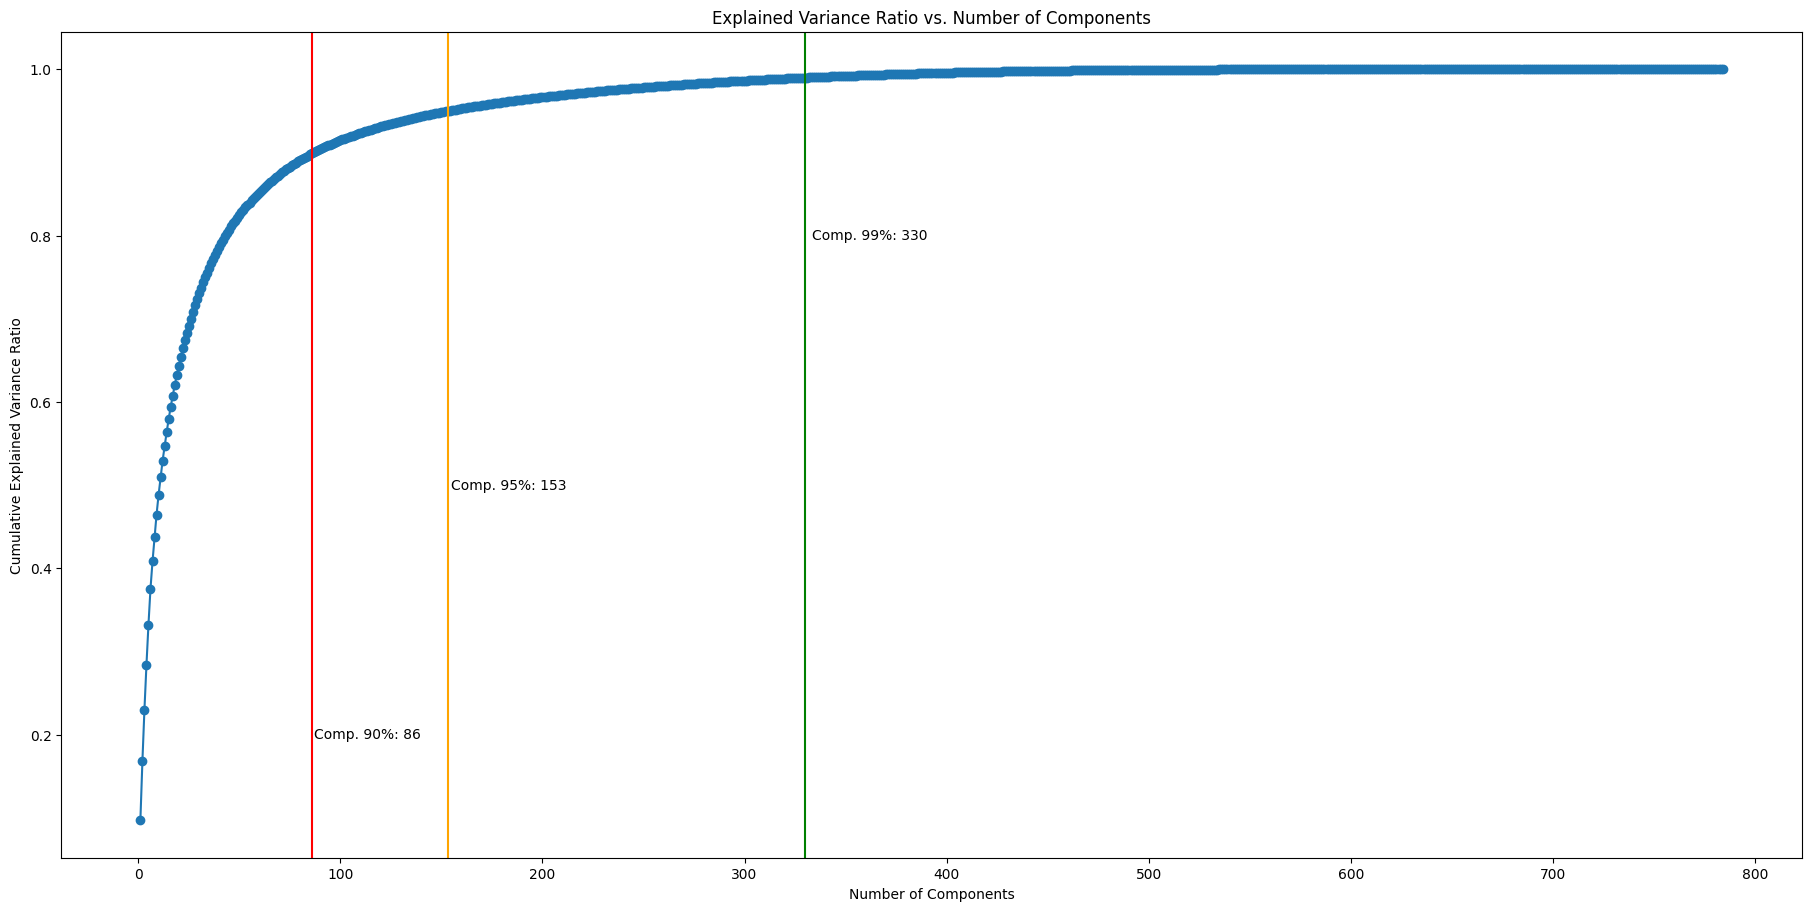

<<< Number of components to preserve variance: 90% - 86 | 95% - 153 | 99% - 330 >>>


In [32]:
# FINDING BEST COMPONENTS TO PRESERVE ENOUGH VARIANCE IN DATA

pca = PCA()
pca.fit(x_train)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
min_component_90 = np.argmax(cumulative_variance_ratio > 0.90)
min_component_95 = np.argmax(cumulative_variance_ratio > 0.95)
min_component_99 = np.argmax(cumulative_variance_ratio > 0.99)

fig, ax = plt.subplots(figsize=(18, 9), layout='constrained')
plt.plot(range(1, len(cumulative_variance_ratio)+1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.axvline(min_component_90, color='red')
ax.text(min_component_90*1.01, 0.2, f'Comp. 90%: {min_component_90}', ha='left', va='center') 
plt.axvline(min_component_95, color='orange')
ax.text(min_component_95*1.01, 0.5, f'Comp. 95%: {min_component_95}', ha='left', va='center') 
plt.axvline(min_component_99, color='green')
ax.text(min_component_99*1.01, 0.8, f'Comp. 99%: {min_component_99}', ha='left', va='center') 

plt.show()

print(f'<<< Number of components to preserve variance: 90% - {min_component_90} | 95% - {min_component_95} | 99% - {min_component_99} >>>')

In [34]:
acc = 0
test_start_time = time.time()
for i in range(5):
    acc += test_model(2, x_pca_train_2, x_pca_test_2)
test_end_time = time.time()
fe_accs['PCA2'] = acc / 5.
fe_times['PCA2'] = (test_end_time - test_start_time) / 5.
print(f'Test accuracy for PCA 2D: {fe_accs["PCA2"]:.2%}. Average time needed for training: {fe_times["PCA2"]:.2f} seconds.')

acc = 0
test_start_time = time.time()
for i in range(5):
    acc += test_model(3, x_pca_train_3, x_pca_test_3)
test_end_time = time.time()
fe_accs['PCA3'] = acc / 5.
fe_times['PCA3'] = (test_end_time - test_start_time) / 5.
print(f'Test accuracy for PCA 3D: {fe_accs["PCA3"]:.2%}. Average time needed for training: {fe_times["PCA3"]:.2f} seconds.')

for dim in [32, 86, 153, 330]:
    start_time = time.time()
    pca = PCA(dim, random_state=42)
    x_pca_train = pca.fit_transform(x_train)
    x_pca_test = pca.transform(x_test)
    end_time = time.time()
    fe_train_times[f'PCA{dim}'] = end_time - start_time
    acc = 0
    test_start_time = time.time()
    for i in range(5):
        acc += test_model(dim, x_pca_train, x_pca_test)
    test_end_time = time.time()
    fe_accs[f'PCA{dim}'] = acc / 5.
    fe_times[f'PCA{dim}'] = (test_end_time - test_start_time) / 5.
    print(f'Test accuracy for PCA {dim}: {fe_accs[f"PCA{dim}"]:.2%}. Average time needed for training: {fe_times[f"PCA{dim}"]:.2f} seconds.')

Test accuracy for PCA 2D: 47.66%. Average time needed for training: 16.32 seconds.
Test accuracy for PCA 3D: 53.57%. Average time needed for training: 16.12 seconds.
Test accuracy for PCA 32: 97.87%. Average time needed for training: 18.30 seconds.
Test accuracy for PCA 86: 98.14%. Average time needed for training: 23.44 seconds.
Test accuracy for PCA 153: 97.93%. Average time needed for training: 28.31 seconds.
Test accuracy for PCA 330: 97.60%. Average time needed for training: 67.77 seconds.


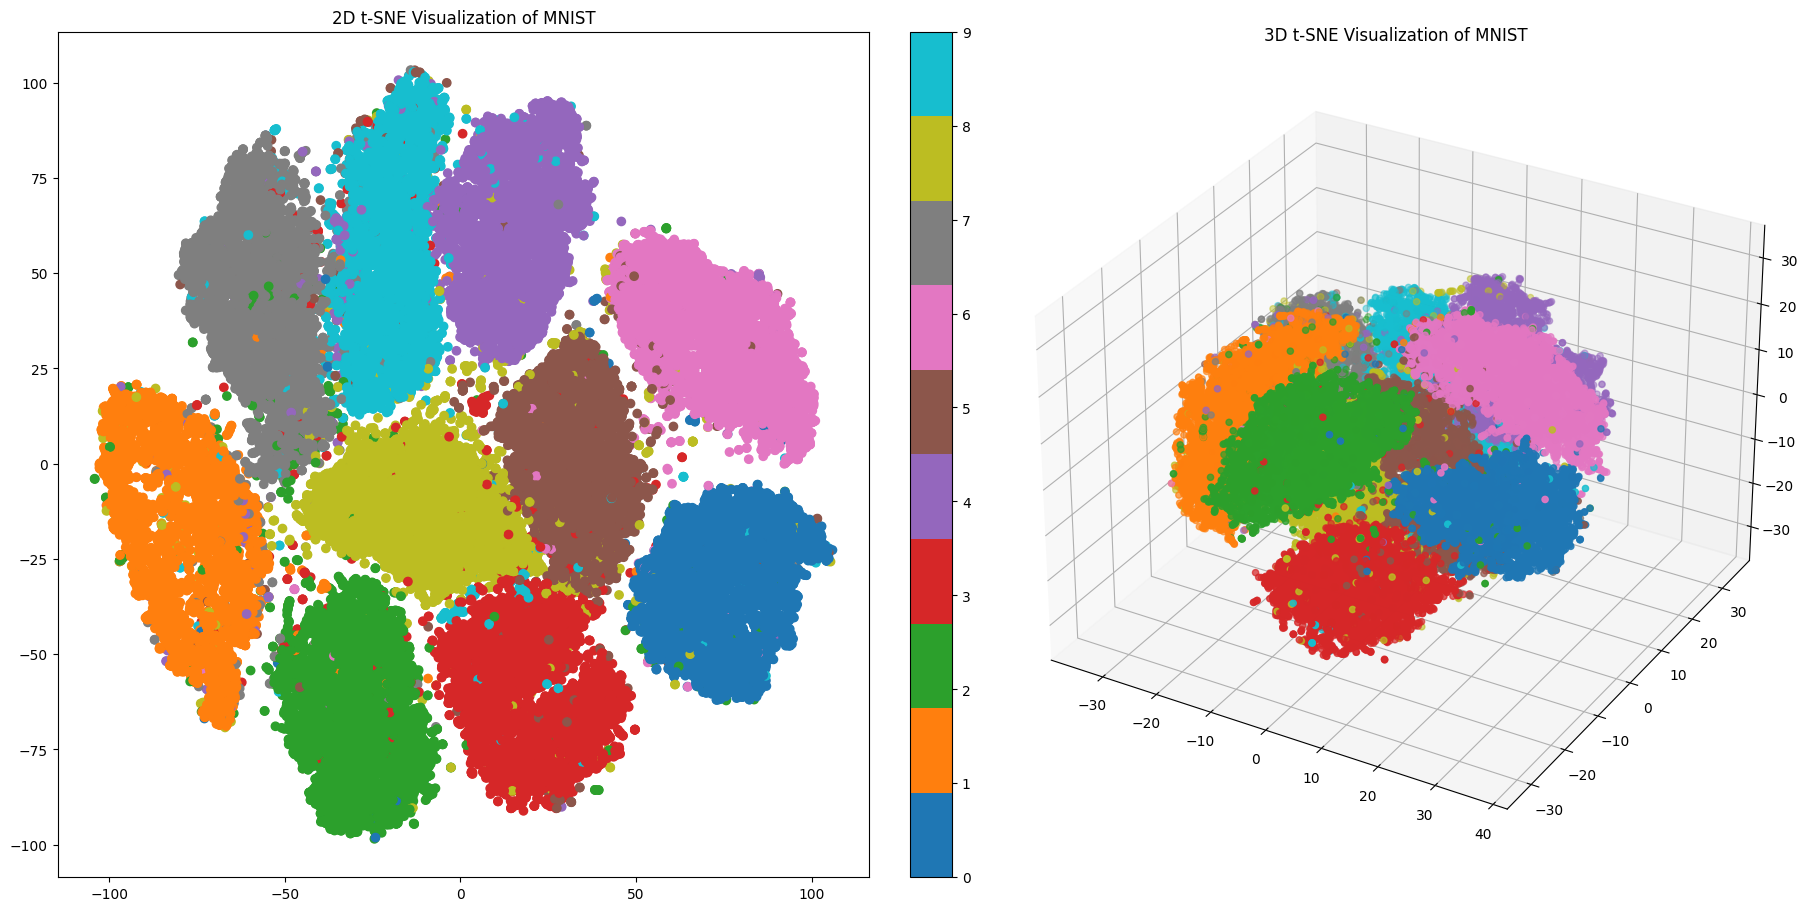

<<< Total time needed to train 2D t-SNE: 270.78. Total time needed to train 3D t-SNE: 716.02 >>>


In [36]:
start_time = time.time()
tsne = TSNE(2, random_state=42)
x_tsne_train_2 = tsne.fit_transform(x_train)
x_tsne_test_2 = tsne.fit_transform(x_test)
end_time = time.time()
fe_train_times['TSNE2'] = end_time - start_time

start_time = time.time()
tsne = TSNE(3, random_state=42)
x_tsne_train_3 = tsne.fit_transform(x_train)
x_tsne_test_3 = tsne.fit_transform(x_test)
end_time = time.time()
fe_train_times['TSNE3'] = end_time - start_time

fig, ax = plt.subplots(figsize=(18, 9), layout='constrained')
plt.axis('off')

ax1 = fig.add_subplot(1, 2, 1)
cb = ax1.scatter(x_tsne_train_2[:, 0], x_tsne_train_2[:, 1], c=y_train, cmap='tab10')
ax1.set_title('2D t-SNE Visualization of MNIST')

plt.colorbar(cb)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(x_tsne_train_3[:, 0], x_tsne_train_3[:, 1], x_tsne_train_3[:, 2], c=y_train, cmap='tab10')
ax2.set_title('3D t-SNE Visualization of MNIST')

plt.show()

print(f'<<< Total time needed to train 2D t-SNE: {fe_train_times["TSNE2"]:.2f}. Total time needed to train 3D t-SNE: {fe_train_times["TSNE3"]:.2f} >>>')

In [37]:
acc = 0
test_start_time = time.time()
for i in range(5):
    acc += test_model(2, x_tsne_train_2, x_tsne_test_2)
test_end_time = time.time()
fe_accs['TSNE2'] = acc / 5.
fe_times['TSNE2'] = (test_end_time - test_start_time) / 5.
print(f'Test accuracy for TSNE 2D: {fe_accs["TSNE2"]:.2%}. Average time needed for training: {fe_times["TSNE2"]:.2f} seconds.')

acc = 0
test_start_time = time.time()
for i in range(5):
    acc += test_model(3, x_tsne_train_3, x_tsne_test_3)
test_end_time = time.time()
fe_accs['TSNE3'] = acc / 5.
fe_times['TSNE3'] = (test_end_time - test_start_time) / 5.
print(f'Test accuracy for TSNE 3D: {fe_accs["TSNE3"]:.2%}. Average time needed for training: {fe_times["TSNE3"]:.2f} seconds.')

Test accuracy for TSNE 2D: 14.92%. Average time needed for training: 17.07 seconds.
Test accuracy for TSNE 3D: 19.24%. Average time needed for training: 16.97 seconds.


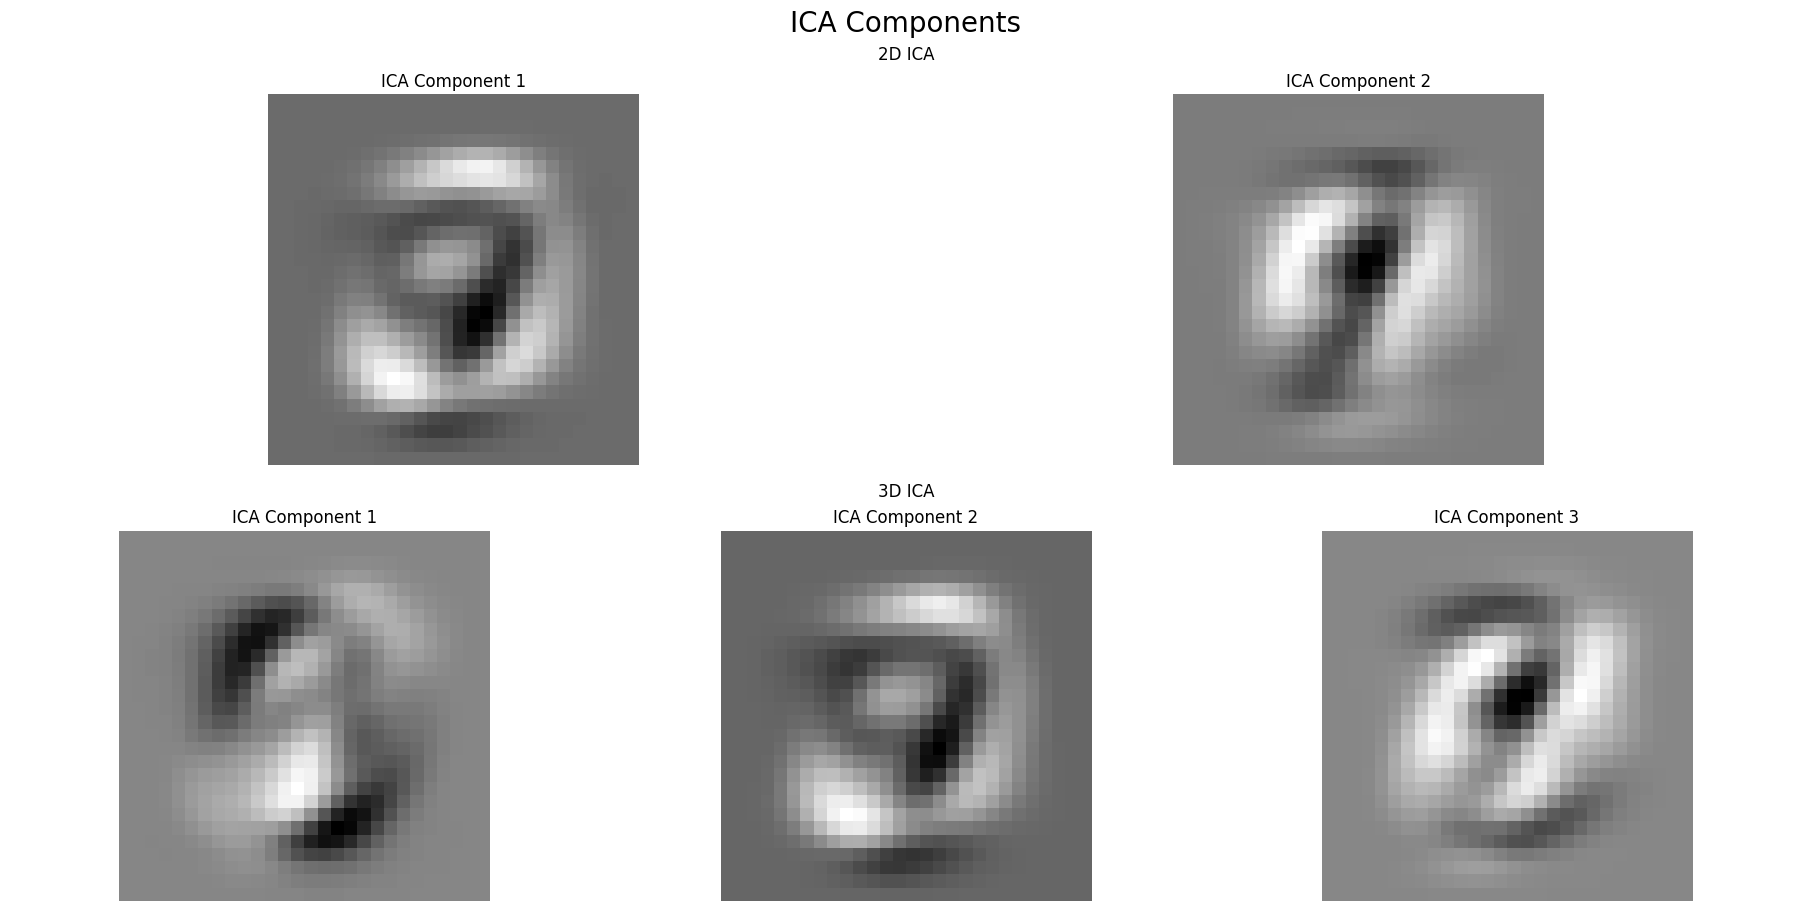

In [38]:
start_time = time.time()
ica2 = FastICA(2, random_state=42, whiten='unit-variance')
x_ica_train_2 = ica2.fit_transform(x_train)
x_ica_test_2 = ica2.transform(x_test)
end_time = time.time()
fe_train_times['ICA2'] = end_time - start_time

fig = plt.figure(figsize=(18, 9), layout='constrained')
subfig = fig.subfigures(2, 1, wspace=0.07)
plt.axis('off')
plt.suptitle('ICA Components', fontsize=20)

subfig[0].suptitle('2D ICA')
for i in range(2):
    ax1 = subfig[0].add_subplot(1, 2, i + 1)
    ax1.imshow(ica2.components_[i].reshape(28, 28), cmap='gray')
    ax1.axis('off')
    ax1.set_title(f'ICA Component {i+1}')

start_time = time.time()
ica3 = FastICA(3, random_state=42, whiten='unit-variance')
x_ica_train_3 = ica3.fit_transform(x_train)
x_ica_test_3 = ica3.transform(x_test)
end_time = time.time()
fe_train_times['ICA3'] = end_time - start_time

subfig[1].suptitle('3D ICA')
for i in range(3):
    ax2 = subfig[1].add_subplot(1, 3, i+1)
    ax2.imshow(ica3.components_[i].reshape(28, 28), cmap='gray')
    ax2.axis('off')
    ax2.set_title(f'ICA Component {i+1}')

plt.show()

In [102]:
acc = 0
test_start_time = time.time()
for i in range(5):
    acc += test_model(2, x_ica_train_2, x_ica_test_2)
test_end_time = time.time()
fe_accs['ICA2'] = acc / 5.
fe_times['ICA2'] = (test_end_time - test_start_time) / 5.
print(f'Test accuracy for ICA 2D: {fe_accs["ICA2"]:.2%}. Average time needed for training: {fe_times["ICA2"]:.2f} seconds.')

acc = 0
test_start_time = time.time()
for i in range(5):
    acc += test_model(3, x_ica_train_3, x_ica_test_3)
test_end_time = time.time()
fe_accs['ICA3'] = acc / 5.
fe_times['ICA3'] = (test_end_time - test_start_time) / 5.
print(f'Test accuracy for ICA 3D: {fe_accs["ICA3"]:.2%}. Average time needed for training: {fe_times["ICA3"]:.2f} seconds.')

for dim in [32, 64, 128]:
    start_time = time.time()
    ica = FastICA(dim, whiten='unit-variance', max_iter=2000, tol=1e-3)
    x_ica_train = ica.fit_transform(x_train)
    x_ica_test = ica.transform(x_test)
    end_time = time.time()
    fe_train_times[f'ICA{dim}'] = end_time - start_time
    acc = 0
    test_start_time = time.time()
    for i in range(5):
        acc += test_model(dim, x_ica_train, x_ica_test)
    test_end_time = time.time()
    fe_accs[f'ICA{dim}'] = acc / 5.
    fe_times[f'ICA{dim}'] = (test_end_time - test_start_time) / 5.
    print(f'Test accuracy for ICA {dim}: {fe_accs[f"ICA{dim}"]:.2%}. Average time needed for training: {fe_times[f"ICA{dim}"]:.2f} seconds.')

Test accuracy for ICA 2D: 47.81%. Average time needed for training: 17.83 seconds.
Test accuracy for ICA 3D: 53.53%. Average time needed for training: 17.40 seconds.
Test accuracy for ICA 32: 96.63%. Average time needed for training: 19.53 seconds.
Test accuracy for ICA 64: 97.57%. Average time needed for training: 23.75 seconds.
Test accuracy for ICA 128: 21.29%. Average time needed for training: 30.30 seconds.


In [104]:
start_time = time.time()
ica = FastICA(128, whiten='unit-variance', max_iter=2000, tol=1e-2)
x_ica_train = ica.fit_transform(x_train)
x_ica_test = ica.transform(x_test)
end_time = time.time()
fe_train_times[f'ICA128'] = end_time - start_time
acc = 0
test_start_time = time.time()
for i in range(5):
    acc += test_model(128, x_ica_train, x_ica_test)
test_end_time = time.time()
fe_accs[f'ICA128'] = acc / 5.
fe_times[f'ICA128'] = (test_end_time - test_start_time) / 5.
print(f'Test accuracy for ICA 128: {fe_accs[f"ICA128"]:.2%}. Average time needed for training: {fe_times[f"ICA128"]:.2f} seconds.')

Test accuracy for ICA 128: 96.93%. Average time needed for training: 29.78 seconds.


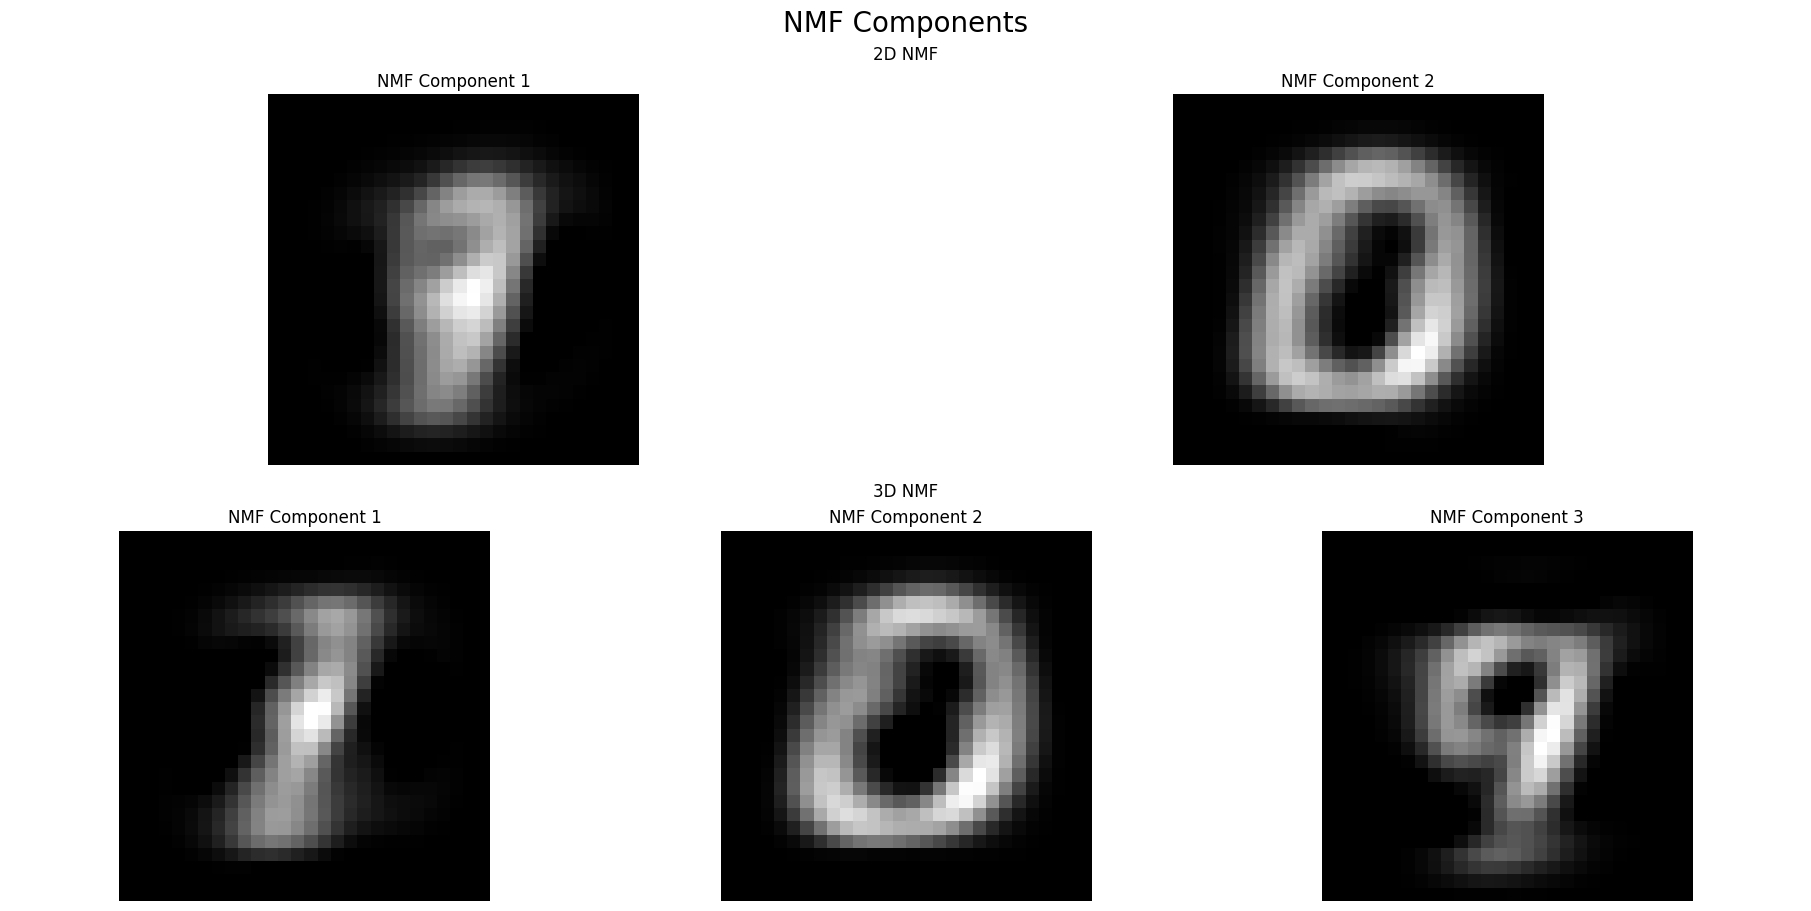

In [42]:
start_time = time.time()
nmf2 = NMF(2, random_state=42)
x_nmf_train_2 = nmf2.fit_transform(x_train)
x_nmf_test_2 = nmf2.transform(x_test)
end_time = time.time()
fe_train_times['NMF2'] = end_time - start_time

fig = plt.figure(figsize=(18, 9), layout='constrained')
subfig = fig.subfigures(2, 1, wspace=0.07)
plt.axis('off')
plt.suptitle('NMF Components', fontsize=20)

subfig[0].suptitle('2D NMF')
for i in range(2):
    ax1 = subfig[0].add_subplot(1, 2, i + 1)
    ax1.imshow(nmf2.components_[i].reshape(28, 28), cmap='gray')
    ax1.axis('off')
    ax1.set_title(f'NMF Component {i+1}')

start_time = time.time()
nmf3 = NMF(3, random_state=42)
x_nmf_train_3 = nmf3.fit_transform(x_train)
x_nmf_test_3 = nmf3.transform(x_test)
end_time = time.time()
fe_train_times['NMF3'] = end_time - start_time

subfig[1].suptitle('3D NMF')
for i in range(3):
    ax2 = subfig[1].add_subplot(1, 3, i + 1)
    ax2.imshow(nmf3.components_[i].reshape(28, 28), cmap='gray')
    ax2.axis('off')
    ax2.set_title(f'NMF Component {i+1}')

plt.show()

In [105]:
acc = 0
test_start_time = time.time()
for i in range(5):
    acc += test_model(2, x_nmf_train_2, x_nmf_test_2)
test_end_time = time.time()
fe_accs['NMF2'] = acc / 5.
fe_times['NMF2'] = (test_end_time - test_start_time) / 5.
print(f'Test accuracy for NMF 2D: {fe_accs["NMF2"]:.2%}. Average time needed for training: {fe_times["NMF2"]:.2f} seconds.')

acc = 0
test_start_time = time.time()
for i in range(5):
    acc += test_model(3, x_nmf_train_3, x_nmf_test_3)
test_end_time = time.time()
fe_accs['NMF3'] = acc / 5.
fe_times['NMF3'] = (test_end_time - test_start_time) / 5.
print(f'Test accuracy for NMF 3D: {fe_accs["NMF3"]:.2%}. Average time needed for training: {fe_times["NMF3"]:.2f} seconds.')

for dim in [32, 64, 128]:
    start_time = time.time()
    nmf = NMF(dim, max_iter=2000)
    x_nmf_train = nmf.fit_transform(x_train)
    x_nmf_test = nmf.transform(x_test)
    end_time = time.time()
    fe_train_times[f'NMF{dim}'] = end_time - start_time
    acc = 0
    test_start_time = time.time()
    for i in range(5):
        acc += test_model(dim, x_nmf_train, x_nmf_test)
    test_end_time = time.time()
    fe_accs[f'NMF{dim}'] = acc / 5.
    fe_times[f'NMF{dim}'] = (test_end_time - test_start_time) / 5.
    print(f'Test accuracy for NMF {dim}: {fe_accs[f"NMF{dim}"]:.2%}. Average time needed for training: {fe_times[f"NMF{dim}"]:.2f} seconds.')

Test accuracy for NMF 2D: 34.53%. Average time needed for training: 17.51 seconds.
Test accuracy for NMF 3D: 51.94%. Average time needed for training: 17.26 seconds.
Test accuracy for NMF 32: 94.82%. Average time needed for training: 19.65 seconds.
Test accuracy for NMF 64: 96.02%. Average time needed for training: 24.25 seconds.
Test accuracy for NMF 128: 95.18%. Average time needed for training: 30.70 seconds.


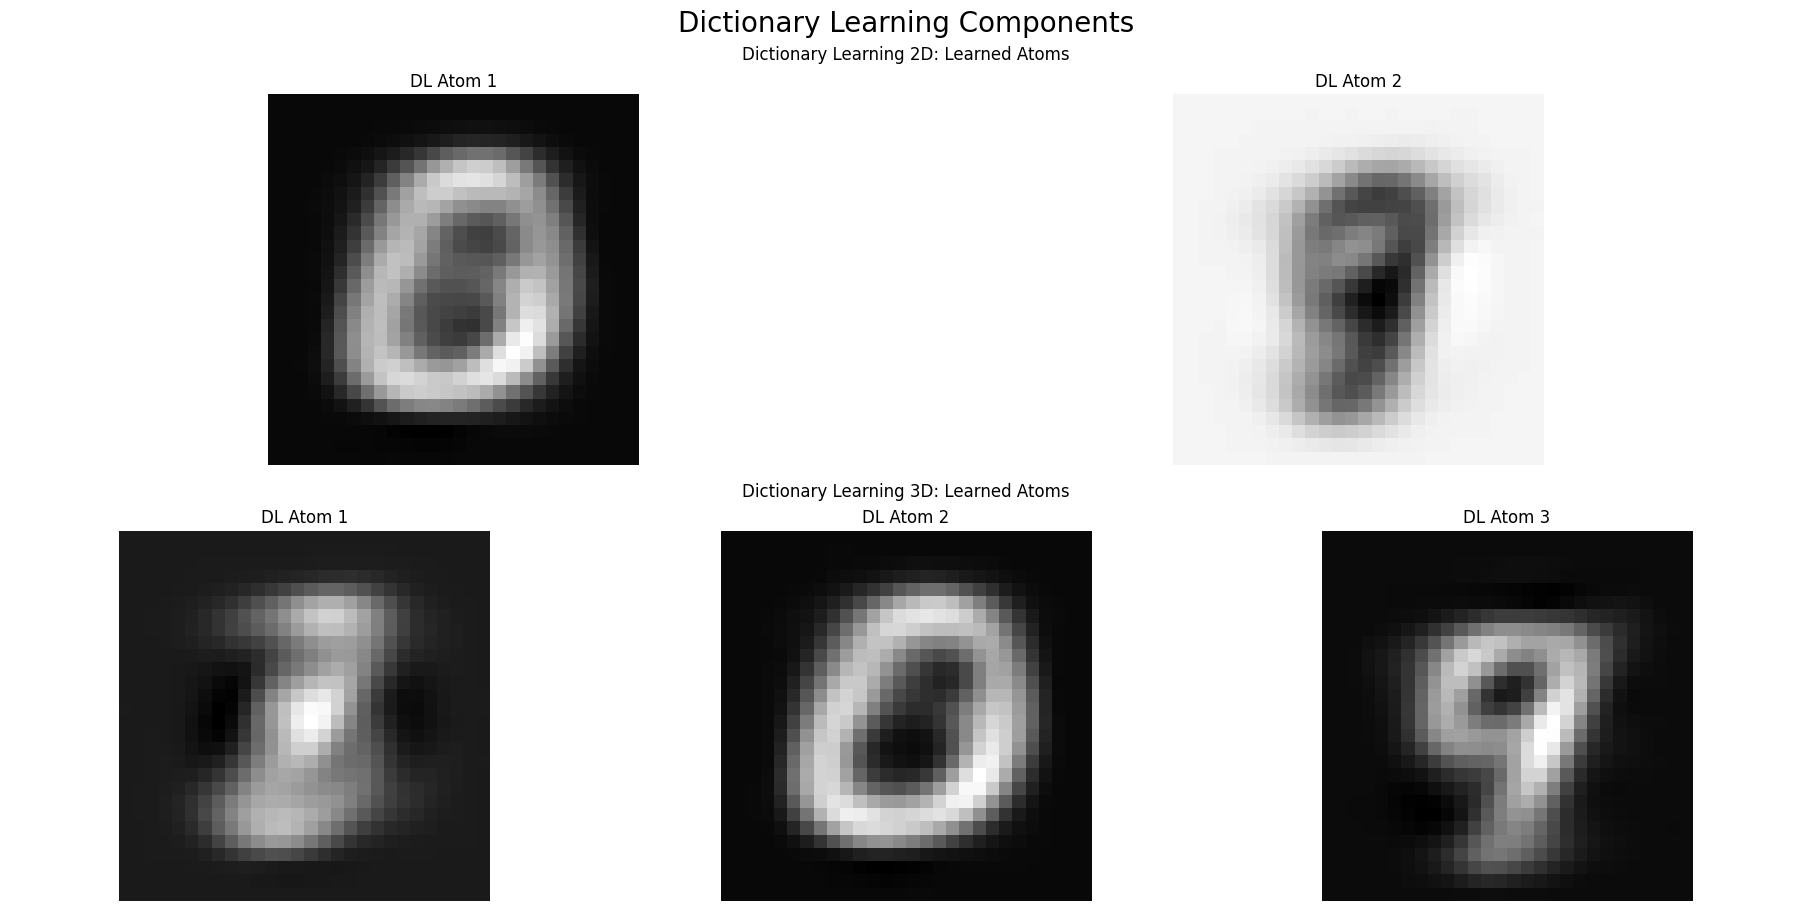

In [106]:
start_time = time.time()
dl2 = MiniBatchDictionaryLearning(2, batch_size=32, random_state=42)
x_dl_train_2 = dl2.fit_transform(x_train)
x_dl_test_2 = dl2.transform(x_test)
end_time = time.time()
fe_train_times['DL2'] = end_time - start_time

fig = plt.figure(figsize=(18, 9), layout='constrained')
subfig = fig.subfigures(2, 1, wspace=0.07)
plt.axis('off')
plt.suptitle('Dictionary Learning Components', fontsize=20)

subfig[0].suptitle('Dictionary Learning 2D: Learned Atoms')
for i in range(2):
    ax1 = subfig[0].add_subplot(1, 2, i + 1)
    ax1.imshow(dl2.components_[i].reshape(28, 28), cmap='gray')
    ax1.axis('off')
    ax1.set_title(f'DL Atom {i+1}')
    
start_time = time.time()
dl3 = MiniBatchDictionaryLearning(3, batch_size=32, random_state=42)
x_dl_train_3 = dl3.fit_transform(x_train)
x_dl_test_3 = dl3.transform(x_test)
end_time = time.time()
fe_train_times['DL3'] = end_time - start_time

subfig[1].suptitle('Dictionary Learning 3D: Learned Atoms')
for i in range(3):
    ax1 = subfig[1].add_subplot(1, 3, i + 1)
    ax1.imshow(dl3.components_[i].reshape(28, 28), cmap='gray')
    ax1.axis('off')
    ax1.set_title(f'DL Atom {i+1}')
    
plt.show()

In [107]:
acc = 0
test_start_time = time.time()
for i in range(5):
    acc += test_model(2, x_dl_train_2, x_dl_test_2)
test_end_time = time.time()
fe_accs['DL2'] = acc / 5.
fe_times['DL2'] = (test_end_time - test_start_time) / 5.
print(f'Test accuracy for DL 2D: {fe_accs["DL2"]:.2%}. Average time needed for training: {fe_times["DL2"]:.2f} seconds.')

acc = 0
test_start_time = time.time()
for i in range(5):
    acc += test_model(3, x_dl_train_3, x_dl_test_3)
test_end_time = time.time()
fe_accs['DL3'] = acc / 5.
fe_times['DL3'] = (test_end_time - test_start_time) / 5.
print(f'Test accuracy for DL 3D: {fe_accs["DL3"]:.2%}. Average time needed for training: {fe_times["DL3"]:.2f} seconds.')

for dim in [32, 64, 128]:
    start_time = time.time()
    dl = MiniBatchDictionaryLearning(dim, batch_size=32, max_iter=1000)
    x_dl_train = dl.fit_transform(x_train)
    x_dl_test = dl.transform(x_test)
    end_time = time.time()
    fe_train_times[f'DL{dim}'] = end_time - start_time
    acc = 0
    test_start_time = time.time()
    for i in range(5):
        acc += test_model(dim, x_dl_train, x_dl_test)
    test_end_time = time.time()
    fe_accs[f'DL{dim}'] = acc / 5.
    fe_times[f'DL{dim}'] = (test_end_time - test_start_time) / 5.
    print(f'Test accuracy for DL {dim}: {fe_accs[f"DL{dim}"]:.2%}. Average time needed for training: {fe_times[f"DL{dim}"]:.2f} seconds.')

Test accuracy for DL 2D: 36.26%. Average time needed for training: 17.91 seconds.
Test accuracy for DL 3D: 53.29%. Average time needed for training: 17.70 seconds.
Test accuracy for DL 32: 97.38%. Average time needed for training: 21.01 seconds.
Test accuracy for DL 64: 97.12%. Average time needed for training: 22.87 seconds.
Test accuracy for DL 128: 95.55%. Average time needed for training: 30.16 seconds.


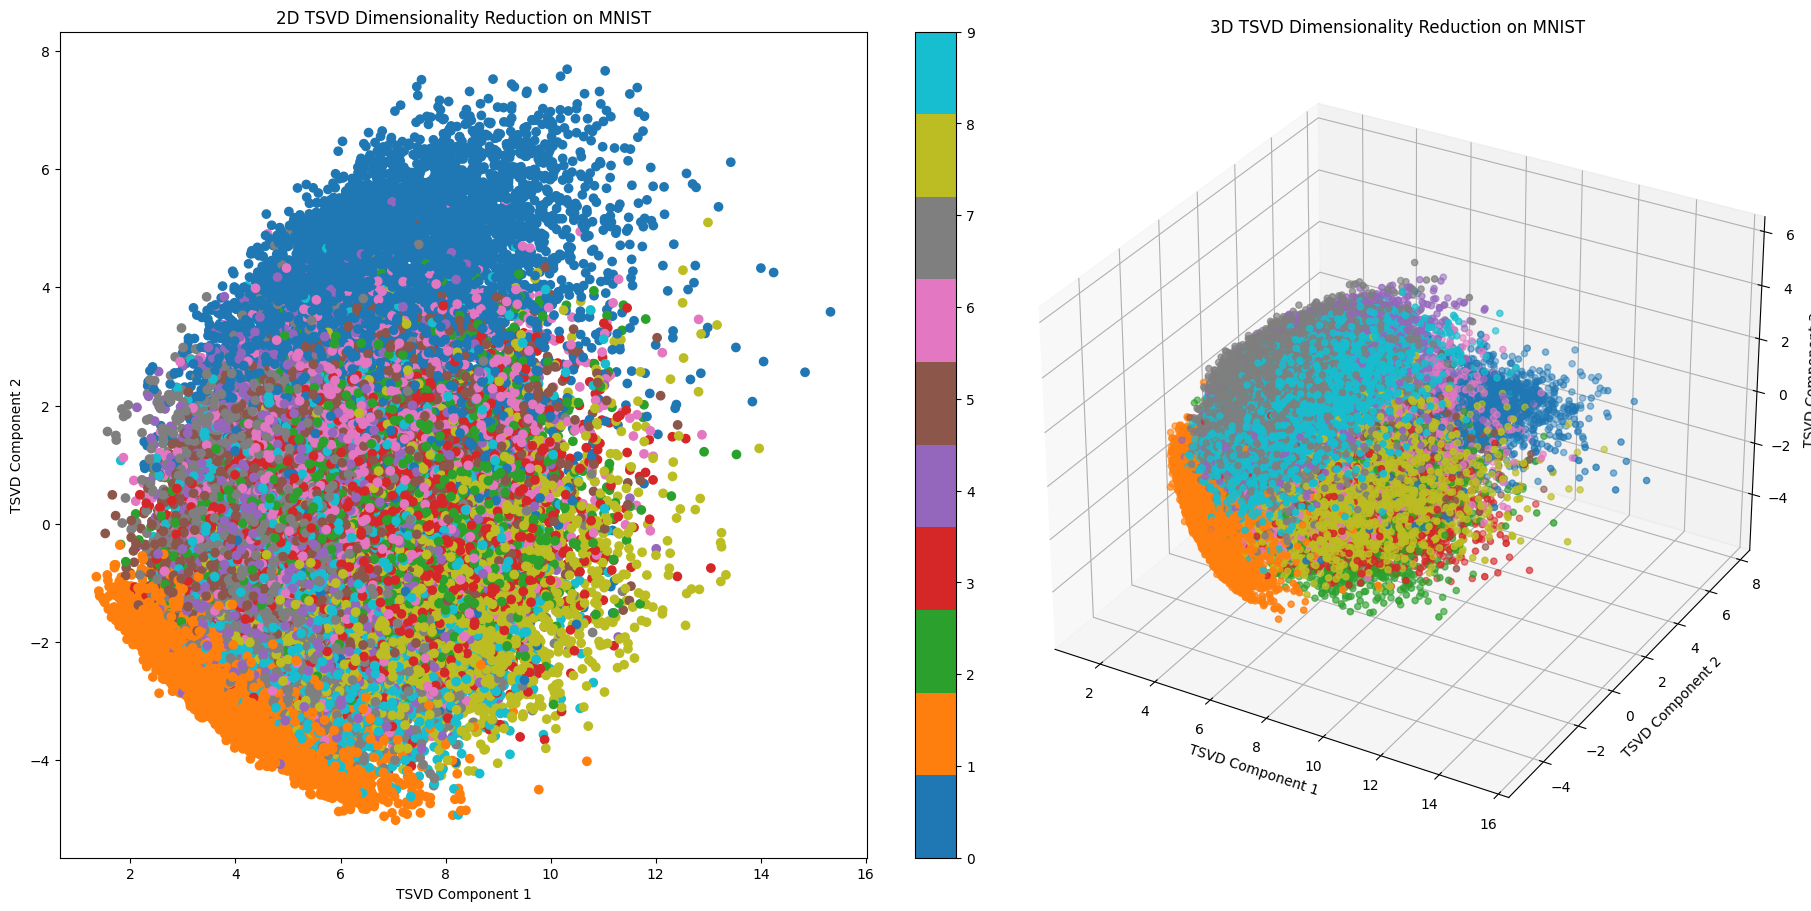

<<< Total preserved variance for 2D: 14.05%. Total preserved variance for 3D: 21.15% >>>


In [46]:
start_time = time.time()
tsvd2 = TruncatedSVD(2, random_state=42)
x_tsvd_train_2 = tsvd2.fit_transform(x_train)
x_tsvd_test_2 = tsvd2.transform(x_test)
end_time = time.time()
fe_train_times['TSVD2'] = end_time - start_time

fig, ax = plt.subplots(figsize=(18, 9), layout='constrained')
plt.axis('off')

ax1 = fig.add_subplot(1, 2, 1)
cb = ax1.scatter(x_tsvd_train_2[:, 0], x_tsvd_train_2[:, 1], c=y_train, cmap='tab10')
ax1.set_xlabel('TSVD Component 1')
ax1.set_ylabel('TSVD Component 2')
ax1.set_title('2D TSVD Dimensionality Reduction on MNIST')

plt.colorbar(cb)

start_time = time.time()
tsvd3 = TruncatedSVD(3, random_state=42)
x_tsvd_train_3 = tsvd3.fit_transform(x_train)
x_tsvd_test_3 = tsvd3.transform(x_test)
end_time = time.time()
fe_train_times['TSVD3'] = end_time - start_time

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(x_tsvd_train_3[:, 0], x_tsvd_train_3[:, 1], x_tsvd_train_3[:, 2], c=y_train, cmap='tab10')
ax2.set_xlabel('TSVD Component 1')
ax2.set_ylabel('TSVD Component 2')
ax2.set_zlabel('TSVD Component 3')
ax2.set_title('3D TSVD Dimensionality Reduction on MNIST')

plt.show()

cumulative_variance_ratio = np.cumsum(tsvd3.explained_variance_ratio_)
print(f'<<< Total preserved variance for 2D: {cumulative_variance_ratio[1]:.2%}. Total preserved variance for 3D: {cumulative_variance_ratio[2]:.2%} >>>')

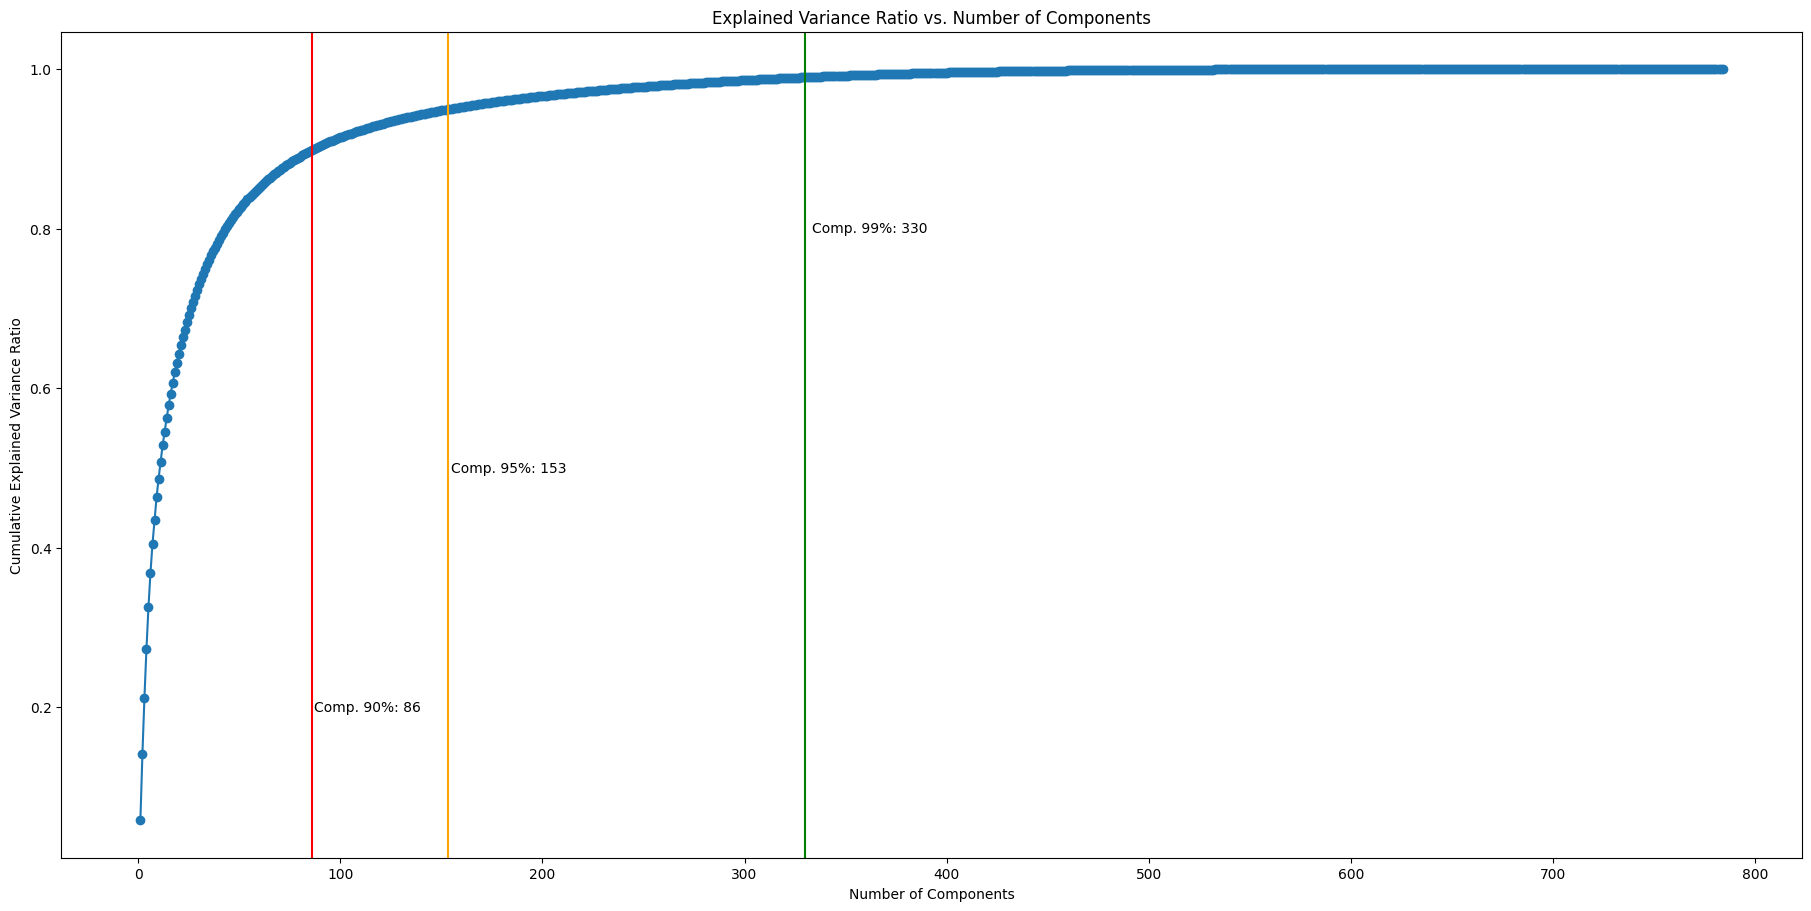

<<< Number of components to preserve variance: 90% - 86 | 95% - 153 | 99% - 330 >>>


In [47]:
tsvd = TruncatedSVD(784)
tsvd.fit(x_train)
cumulative_variance_ratio = np.cumsum(tsvd.explained_variance_ratio_)
min_component_90 = np.argmax(cumulative_variance_ratio > 0.90)
min_component_95 = np.argmax(cumulative_variance_ratio > 0.95)
min_component_99 = np.argmax(cumulative_variance_ratio > 0.99)

fig, ax = plt.subplots(figsize=(18, 9), layout='constrained')
plt.plot(range(1, len(cumulative_variance_ratio)+1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.axvline(min_component_90, color='red')
ax.text(min_component_90*1.01, 0.2, f'Comp. 90%: {min_component_90}', ha='left', va='center') 
plt.axvline(min_component_95, color='orange')
ax.text(min_component_95*1.01, 0.5, f'Comp. 95%: {min_component_95}', ha='left', va='center') 
plt.axvline(min_component_99, color='green')
ax.text(min_component_99*1.01, 0.8, f'Comp. 99%: {min_component_99}', ha='left', va='center') 

plt.show()

print(f'<<< Number of components to preserve variance: 90% - {min_component_90} | 95% - {min_component_95} | 99% - {min_component_99} >>>')

In [48]:
acc = 0
test_start_time = time.time()
for i in range(5):
    acc += test_model(2, x_tsvd_train_2, x_tsvd_test_2)
test_end_time = time.time()
fe_accs['TSVD2'] = acc / 5.
fe_times['TSVD2'] = (test_end_time - test_start_time) / 5.
print(f'Test accuracy for TSVD 2D: {fe_accs["TSVD2"]:.2%}. Average time needed for training: {fe_times["TSVD2"]:.2f} seconds.')

acc = 0
test_start_time = time.time()
for i in range(5):
    acc += test_model(3, x_tsvd_train_3, x_tsvd_test_3)
test_end_time = time.time()
fe_accs['TSVD3'] = acc / 5.
fe_times['TSVD3'] = (test_end_time - test_start_time) / 5.
print(f'Test accuracy for TSVD 3D: {fe_accs["TSVD3"]:.2%}. Average time needed for training: {fe_times["TSVD3"]:.2f} seconds.')

for dim in [32, 86, 153, 330]:
    start_time = time.time()
    tsvd = TruncatedSVD(dim, random_state=42)
    x_tsvd_train = tsvd.fit_transform(x_train)
    x_tsvd_test = tsvd.transform(x_test)
    end_time = time.time()
    fe_train_times[f'TSVD{dim}'] = end_time - start_time
    acc = 0
    test_start_time = time.time()
    for i in range(5):
        acc += test_model(dim, x_tsvd_train, x_tsvd_test)
    test_end_time = time.time()
    fe_accs[f'TSVD{dim}'] = acc / 5.
    fe_times[f'TSVD{dim}'] = (test_end_time - test_start_time) / 5.
    print(f'Test accuracy for TSVD {dim}: {fe_accs[f"TSVD{dim}"]:.2%}. Average time needed for training: {fe_times[f"TSVD{dim}"]:.2f} seconds.')

Test accuracy for TSVD 2D: 35.33%. Average time needed for training: 16.64 seconds.
Test accuracy for TSVD 3D: 53.66%. Average time needed for training: 16.99 seconds.
Test accuracy for TSVD 32: 98.18%. Average time needed for training: 18.58 seconds.
Test accuracy for TSVD 86: 98.15%. Average time needed for training: 24.20 seconds.
Test accuracy for TSVD 153: 97.94%. Average time needed for training: 30.45 seconds.
Test accuracy for TSVD 330: 97.84%. Average time needed for training: 68.19 seconds.


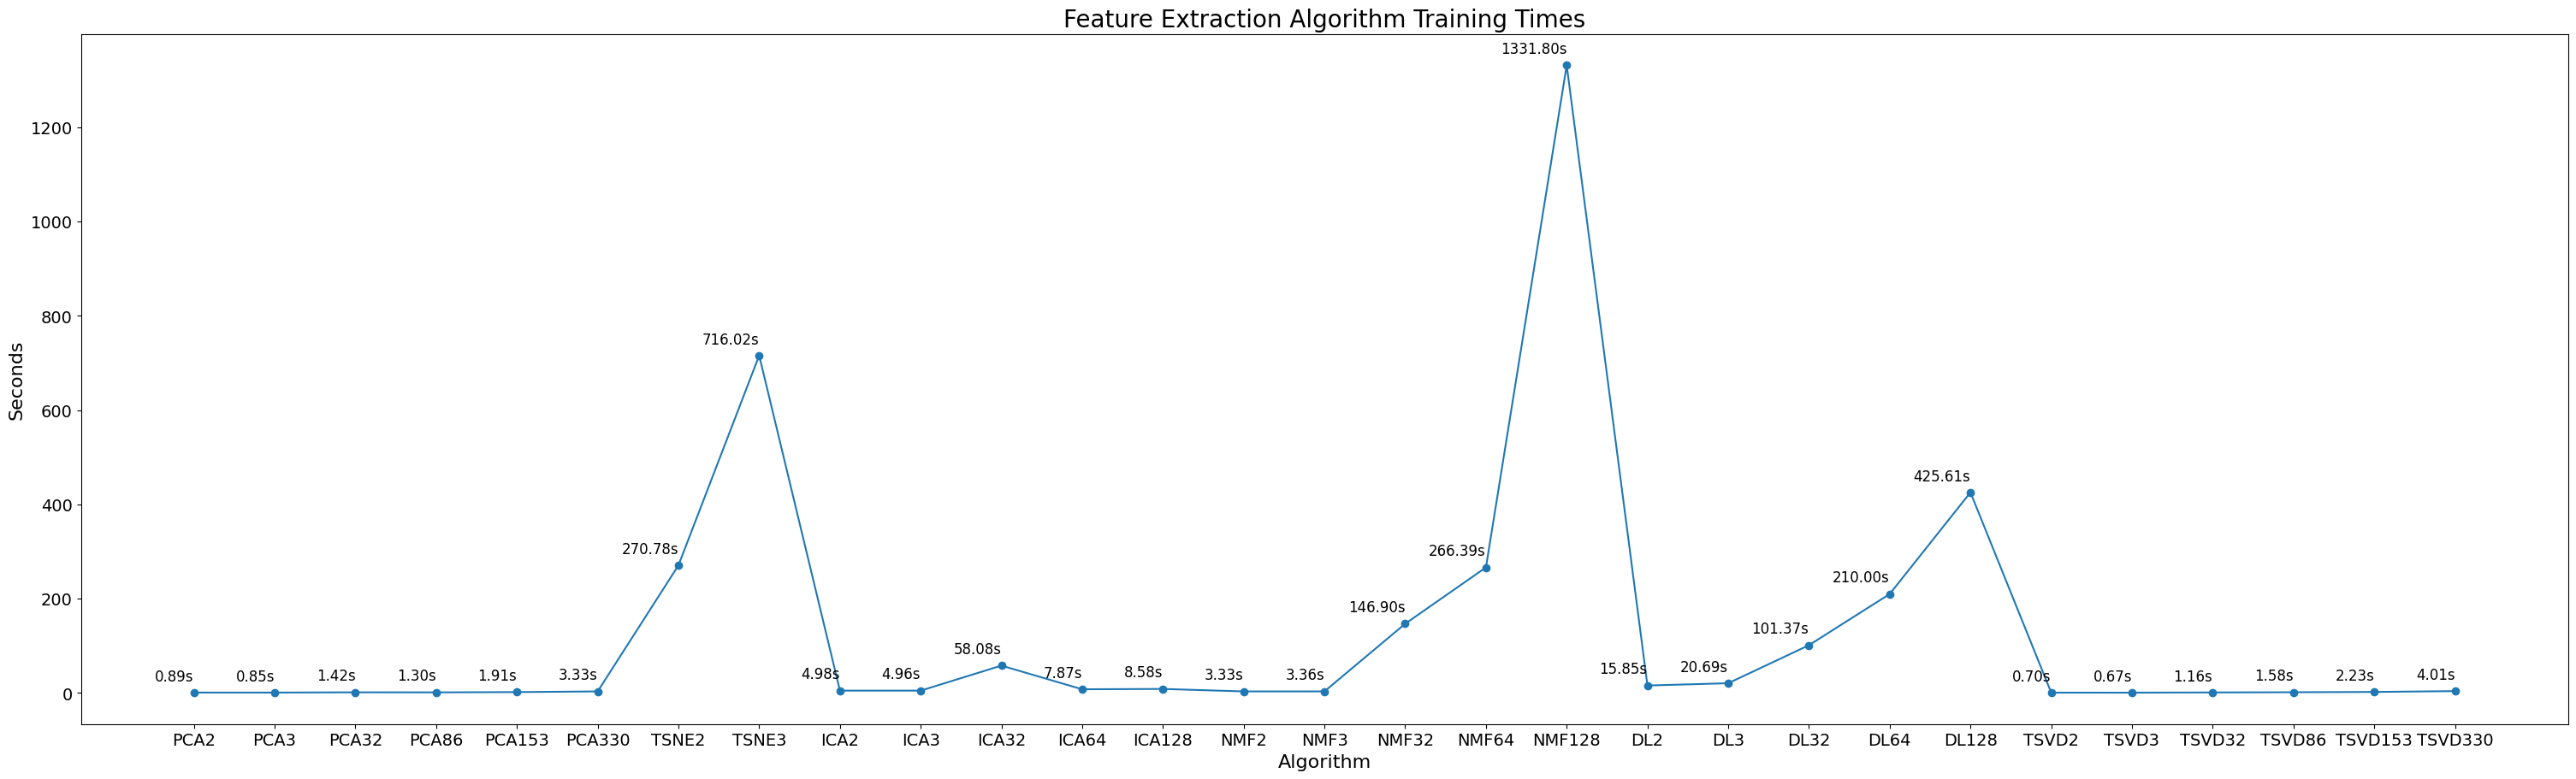

Time needed to train PCA2 algorithm: 0.89 seconds.
Time needed to train PCA3 algorithm: 0.85 seconds.
Time needed to train PCA32 algorithm: 1.42 seconds.
Time needed to train PCA86 algorithm: 1.30 seconds.
Time needed to train PCA153 algorithm: 1.91 seconds.
Time needed to train PCA330 algorithm: 3.33 seconds.
Time needed to train TSNE2 algorithm: 270.78 seconds.
Time needed to train TSNE3 algorithm: 716.02 seconds.
Time needed to train ICA2 algorithm: 4.98 seconds.
Time needed to train ICA3 algorithm: 4.96 seconds.
Time needed to train ICA32 algorithm: 58.08 seconds.
Time needed to train ICA64 algorithm: 7.87 seconds.
Time needed to train ICA128 algorithm: 8.58 seconds.
Time needed to train NMF2 algorithm: 3.33 seconds.
Time needed to train NMF3 algorithm: 3.36 seconds.
Time needed to train NMF32 algorithm: 146.90 seconds.
Time needed to train NMF64 algorithm: 266.39 seconds.
Time needed to train NMF128 algorithm: 1331.80 seconds.
Time needed to train DL2 algorithm: 15.85 seconds.
Tim

In [117]:
keys = list(fe_train_times)
values = list(fe_train_times.values())
fig, ax = plt.subplots(figsize=(30, 9), layout='constrained')
plt.plot(keys, values, marker='o')
plt.xlabel('Algorithm', fontsize=16)
plt.ylabel('Seconds', fontsize=16)
plt.xticks(keys, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Feature Extraction Algorithm Training Times', fontsize=20)

for i in range(len(keys)):
    plt.annotate(f'{values[i]:.2f}s', (keys[i], values[i]), textcoords="offset points", xytext=(0, 10), ha='right', fontsize=12)

plt.show()

for k, v in fe_train_times.items():
    print(f'Time needed to train {k} algorithm: {v:.2f} seconds.')

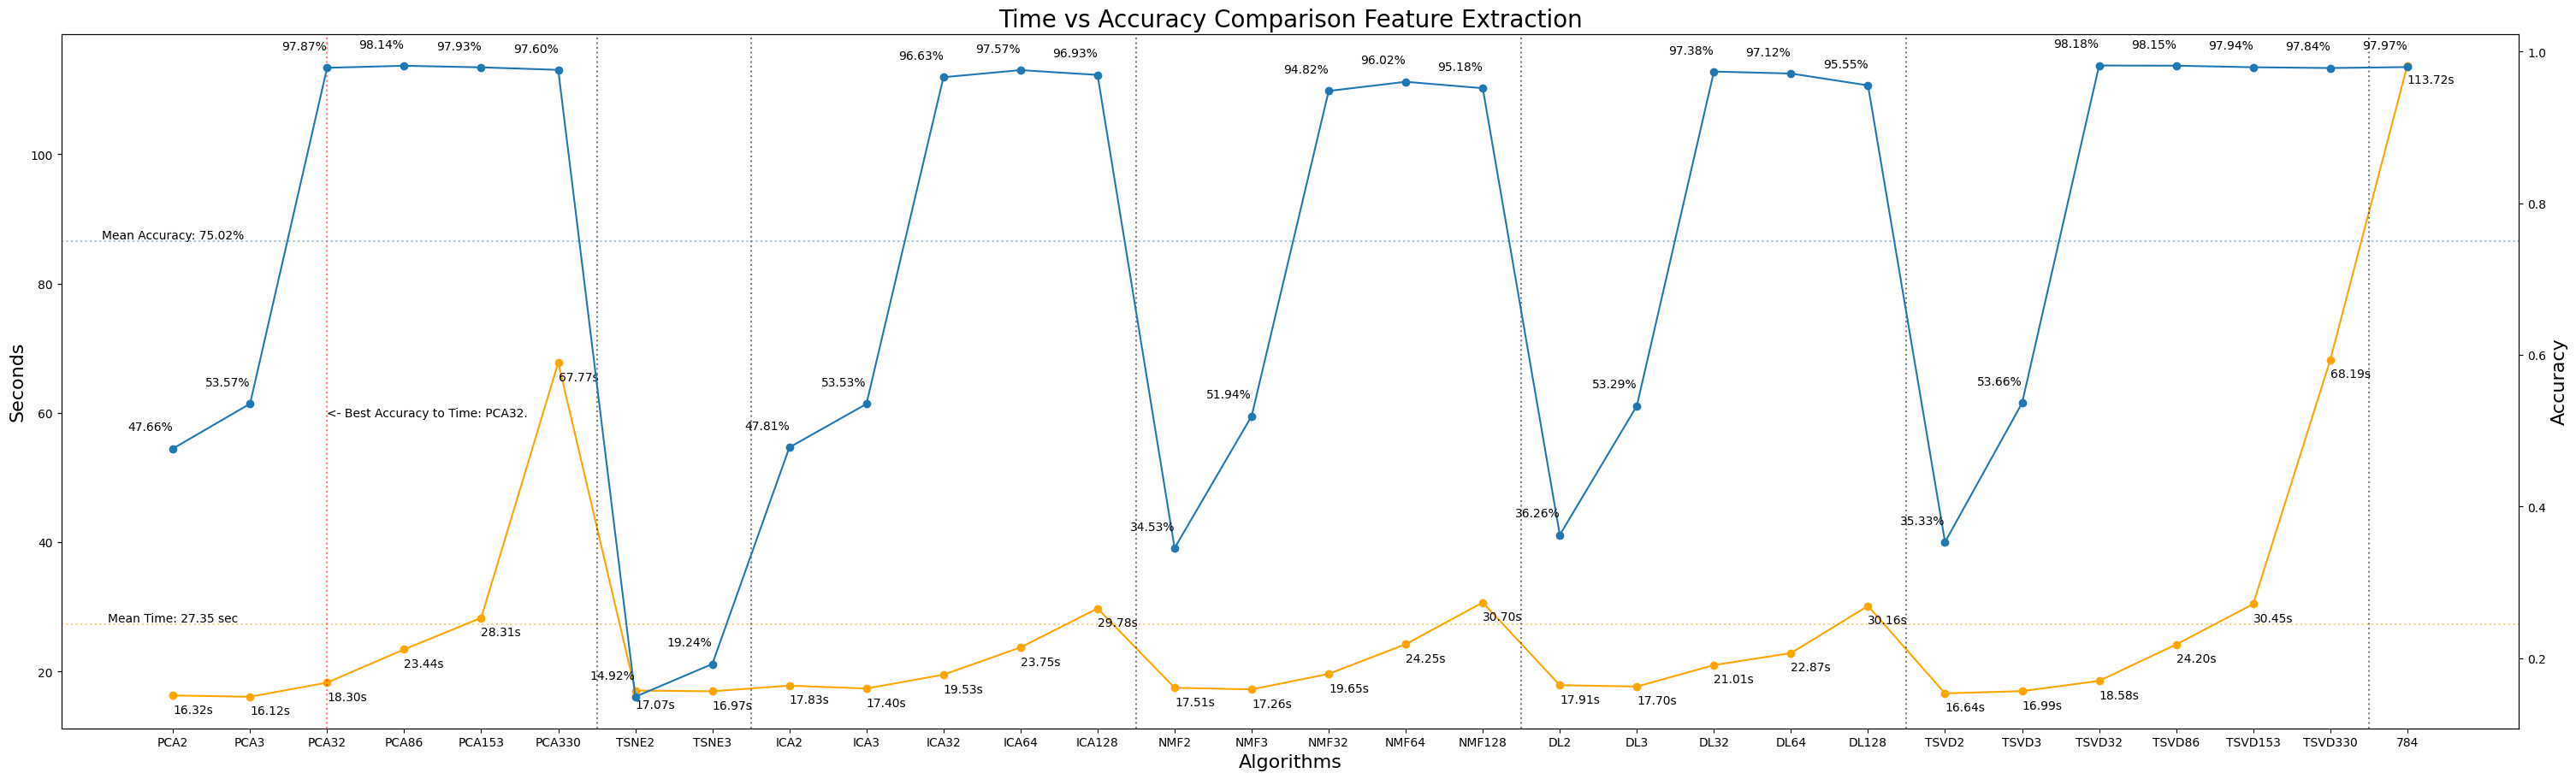

<<< Best accuracy compared to time is for PCA32 algorithm. >>>


In [137]:
time_keys = list(fe_times)
time_values = list(fe_times.values())
time_keys.append('784')
time_values.append(base_time) 

acc_keys = list(fe_accs)
acc_values = list(fe_accs.values())
acc_keys.append('784')
acc_values.append(base_mnist)

mean_time = np.mean(time_values)
mean_acc = np.mean(acc_values)

fig, ax1 = plt.subplots(figsize=(30, 9), layout='constrained')
plt.title('Time vs Accuracy Comparison Feature Extraction', fontsize=20)
ax1.plot(time_keys, time_values, marker='o', color='orange')
ax1.set_xlabel('Algorithms', fontsize=16)
ax1.set_ylabel('Seconds', fontsize=16)

ax2 = ax1.twinx()
ax2.plot(acc_keys, acc_values, marker='o')
ax2.set_ylabel('Accuracy', fontsize=16)

for i in range(len(time_keys)):
    ax1.annotate(f'{time_values[i]:.2f}s', (time_keys[i], time_values[i]), textcoords='offset points', xytext=(0, -15), ha='left')
    ax2.annotate(f'{acc_values[i]:.2%}', (acc_keys[i], acc_values[i]), textcoords='offset points', xytext=(0, 15), ha='right')

ax1.axhline(mean_time, color='orange', linestyle=':', label='Mean Time', alpha=0.5)
ax1.text(0, mean_time, f'Mean Time: {mean_time:.2f} sec', ha='center', va='bottom')
ax2.axhline(mean_acc, color='steelblue', linestyle=':', label='Mean Acc', alpha=0.5)
ax2.text(0, mean_acc, f'Mean Accuracy: {mean_acc:.2%}', ha='center', va='bottom')

worth = np.divide(acc_values, time_values)
best_alg = time_keys[np.argmax(worth)]

ax1.axvline(2, color='red', linestyle=':', label='Highest Value', alpha=0.5)
ax1.text(2, 60, f'<- Best Accuracy to Time: {best_alg}.', ha='left', va='center')

ax1.axvline(5.5, color='black', linestyle=':', label='1', alpha=0.5)
ax1.axvline(7.5, color='black', linestyle=':', label='2', alpha=0.5)
ax1.axvline(12.5, color='black', linestyle=':', label='3', alpha=0.5)
ax1.axvline(17.5, color='black', linestyle=':', label='4', alpha=0.5)
ax1.axvline(22.5, color='black', linestyle=':', label='5', alpha=0.5)
ax1.axvline(28.5, color='black', linestyle=':', label='6', alpha=0.5)

plt.show()

print(f'<<< Best accuracy compared to time is for {best_alg} algorithm. >>>')

In [138]:
data = {
    'Training Time (s)': pd.Series(fe_train_times),
    'Accuracy (%)': pd.Series(fe_accs),
    'Test Time (s)': pd.Series(fe_times),
    'Total Time (s)': pd.Series({key: fe_train_times[key] + fe_times[key] for key in fe_train_times})
}

df = pd.DataFrame(data)

df['Training Time (s)'] = df['Training Time (s)'].map("{:.2f}".format)
df['Accuracy (%)'] = df['Accuracy (%)'].map("{:.2%}".format)
df['Test Time (s)'] = df['Test Time (s)'].map("{:.2f}".format)
df['Total Time (s)'] = df['Total Time (s)'].map("{:.2f}".format)

df

Training Time (s) Accuracy (%) Test Time (s) Total Time (s)
PCA2                 0.89       47.66%         16.32          17.21
PCA3                 0.85       53.57%         16.12          16.97
PCA32                1.42       97.87%         18.30          19.73
PCA86                1.30       98.14%         23.44          24.74
PCA153               1.91       97.93%         28.31          30.22
PCA330               3.33       97.60%         67.77          71.10
TSNE2              270.78       14.92%         17.07         287.85
TSNE3              716.02       19.24%         16.97         732.99
ICA2                 4.98       47.81%         17.83          22.82
ICA3                 4.96       53.53%         17.40          22.36
ICA32               58.08       96.63%         19.53          77.61
ICA64                7.87       97.57%         23.75          31.62
ICA128               8.58       96.93%         29.78          38.36
NMF2                 3.33       34.53%         17.51          20.83
NMF3                 3.36       51.94%         17.26          20.62
NMF32              146.90       94.82%         19.65         166.55
NMF64              266.39       96.02%         24.25         290.64
NMF128            1331.80       95.18%         30.70        1362.50
DL2                 15.85       36.26%         17.91          33.75
DL3                 20.69       53.29%         17.70          38.39
DL32               101.37       97.38%         21.01         122.38
DL64               210.00       97.12%         22.87         232.87
DL128              425.61       95.55%         30.16         455.77
TSVD2                0.70       35.33%         16.64          17.34
TSVD3                0.67       53.66%         16.99          17.66
TSVD32               1.16       98.18%         18.58          19.74
TSVD86               1.58       98.15%         24.20          25.78
TSVD153              2.23       97.94%         30.45          32.68
TSVD330              4.01       97.84%         68.19          72.20

In [139]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, VarianceThreshold, SelectFromModel, RFE, RFECV, SequentialFeatureSelector
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

# MNIST DATASET

(x_train, y_train), (x_test, y_test) = mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

img_shape=x_train.shape[1:]

fs_train_times = {}
fs_accs = {}
fs_times = {}

In [140]:
for score in [chi2, mutual_info_classif]:
    for dim in [32, 64, 128]:
        start_time = time.time()
        select_k_best = SelectKBest(score_func=score, k=dim)
        x_train_selected = select_k_best.fit_transform(x_train, y_train)
        x_test_selected = select_k_best.transform(x_test)
        end_time = time.time()
        fs_train_times[f'SKB{dim}{score.__name__}'] = end_time - start_time
        acc = 0
        test_start_time = time.time()
        for i in range(5):
            acc += test_model(dim, x_train_selected, x_test_selected)
        test_end_time = time.time()
        fs_accs[f'SKB{dim}{score.__name__}'] = acc / 5.
        fs_times[f'SKB{dim}{score.__name__}'] = (test_end_time - test_start_time) / 5.
        print(f'Test accuracy for SelectKBest {dim} {score.__name__}: {fs_accs[f"SKB{dim}{score.__name__}"]:.2%}. Average time needed for training: {fs_times[f"SKB{dim}{score.__name__}"]:.2f} seconds.')

Test accuracy for SelectKBest 32 chi2: 69.24%. Average time needed for training: 22.08 seconds.
Test accuracy for SelectKBest 64 chi2: 85.07%. Average time needed for training: 24.51 seconds.
Test accuracy for SelectKBest 128 chi2: 93.59%. Average time needed for training: 31.65 seconds.
Test accuracy for SelectKBest 32 mutual_info_classif: 85.39%. Average time needed for training: 21.53 seconds.
Test accuracy for SelectKBest 64 mutual_info_classif: 90.64%. Average time needed for training: 23.60 seconds.
Test accuracy for SelectKBest 128 mutual_info_classif: 96.16%. Average time needed for training: 30.73 seconds.


In [141]:
for score in [chi2, mutual_info_classif]:
    for dim in [5, 10, 15]:
        start_time = time.time()
        select_percentile = SelectPercentile(score_func=score, percentile=dim)
        x_train_selected = select_percentile.fit_transform(x_train, y_train)
        x_test_selected = select_percentile.transform(x_test)
        end_time = time.time()
        fs_train_times[f'SP{dim}{score.__name__}'] = end_time - start_time
        acc = 0
        test_start_time = time.time()
        for i in range(5):
            acc += test_model(x_train_selected.shape[1], x_train_selected, x_test_selected)
        test_end_time = time.time()
        fs_accs[f'SP{dim}{score.__name__}'] = acc / 5.
        fs_times[f'SP{dim}{score.__name__}'] = (test_end_time - test_start_time) / 5.
        print(f'Test accuracy for SelectPercentile {dim}% {score.__name__}: {fs_accs[f"SP{dim}{score.__name__}"]:.2%}. Average time needed for training: {fs_times[f"SP{dim}{score.__name__}"]:.2f} seconds.')

Test accuracy for SelectPercentile 5% chi2: 71.45%. Average time needed for training: 22.56 seconds.
Test accuracy for SelectPercentile 10% chi2: 88.86%. Average time needed for training: 26.96 seconds.
Test accuracy for SelectPercentile 15% chi2: 93.10%. Average time needed for training: 30.99 seconds.
Test accuracy for SelectPercentile 5% mutual_info_classif: 88.03%. Average time needed for training: 21.33 seconds.
Test accuracy for SelectPercentile 10% mutual_info_classif: 93.42%. Average time needed for training: 25.77 seconds.
Test accuracy for SelectPercentile 15% mutual_info_classif: 95.40%. Average time needed for training: 29.04 seconds.


In [142]:
for dim in [0.19, 0.185, 0.18]: # 1905 - 33, 18 - 130, 188 - 65 | 19 - 42, 185 - 99, 18 - 130
    start_time = time.time()
    variance_threshold = VarianceThreshold(threshold=dim)
    x_train_selected = variance_threshold.fit_transform(x_train)
    x_test_selected = variance_threshold.transform(x_test)
    end_time = time.time()
    fs_train_times[f'VT{x_train_selected.shape[1]}'] = end_time - start_time
    acc = 0
    test_start_time = time.time()
    for i in range(5):
        acc += test_model(x_train_selected.shape[1], x_train_selected, x_test_selected)
    test_end_time = time.time()
    fs_accs[f'VT{x_train_selected.shape[1]}'] = acc / 5.
    fs_times[f'VT{x_train_selected.shape[1]}'] = (test_end_time - test_start_time) / 5.
    print(f'Test accuracy for VarianceThreshold {dim} {x_train_selected.shape[1]} features: {fs_accs[f"VT{x_train_selected.shape[1]}"]:.2%}. Average time needed for training: {fs_times[f"VT{x_train_selected.shape[1]}"]:.2f} seconds.')

Test accuracy for VarianceThreshold 0.19 42 features: 89.57%. Average time needed for training: 20.94 seconds.
Test accuracy for VarianceThreshold 0.185 99 features: 94.95%. Average time needed for training: 29.59 seconds.
Test accuracy for VarianceThreshold 0.18 130 features: 96.10%. Average time needed for training: 34.24 seconds.


In [143]:
start_time = time.time()
extra_trees = ExtraTreesClassifier(random_state=42)
extra_trees.fit(x_train, y_train)
model = SelectFromModel(extra_trees, prefit=True)
x_train_selected = model.transform(x_train)
x_test_selected = model.transform(x_test)
end_time = time.time()
fs_train_times['ETC'] = end_time - start_time

importances = extra_trees.feature_importances_
indices = np.argsort(importances)[::-1]

print('Top 10 feature importances:')
for i, idx in enumerate(indices[:10]):
    print(f'{i+1}. Feature {idx}: Importance {importances[idx]:.2%}')
print(f'<<< Selected number of features: {x_train_selected.shape[1]}. >>>')

acc = 0
test_start_time = time.time()
for i in range(5):
    acc += test_model(x_train_selected.shape[1], x_train_selected, x_test_selected)
test_end_time = time.time()
fs_accs['ETC'] = acc / 5.
fs_times['ETC'] = (test_end_time - test_start_time) / 5.
print(f'Test accuracy for ExtraTrees with {x_train_selected.shape[1]} features: {fs_accs["ETC"]:.2%}. Average time needed for training: {fs_times["ETC"]:.2f} seconds.')

Top 10 feature importances:
1. Feature 378: Importance 1.14%
2. Feature 350: Importance 0.97%
3. Feature 406: Importance 0.77%
4. Feature 433: Importance 0.72%
5. Feature 515: Importance 0.71%
6. Feature 434: Importance 0.68%
7. Feature 489: Importance 0.65%
8. Feature 461: Importance 0.65%
9. Feature 462: Importance 0.64%
10. Feature 405: Importance 0.64%
<<< Selected number of features: 276. >>>
Test accuracy for ExtraTrees with 276 features: 98.01%. Average time needed for training: 47.36 seconds.


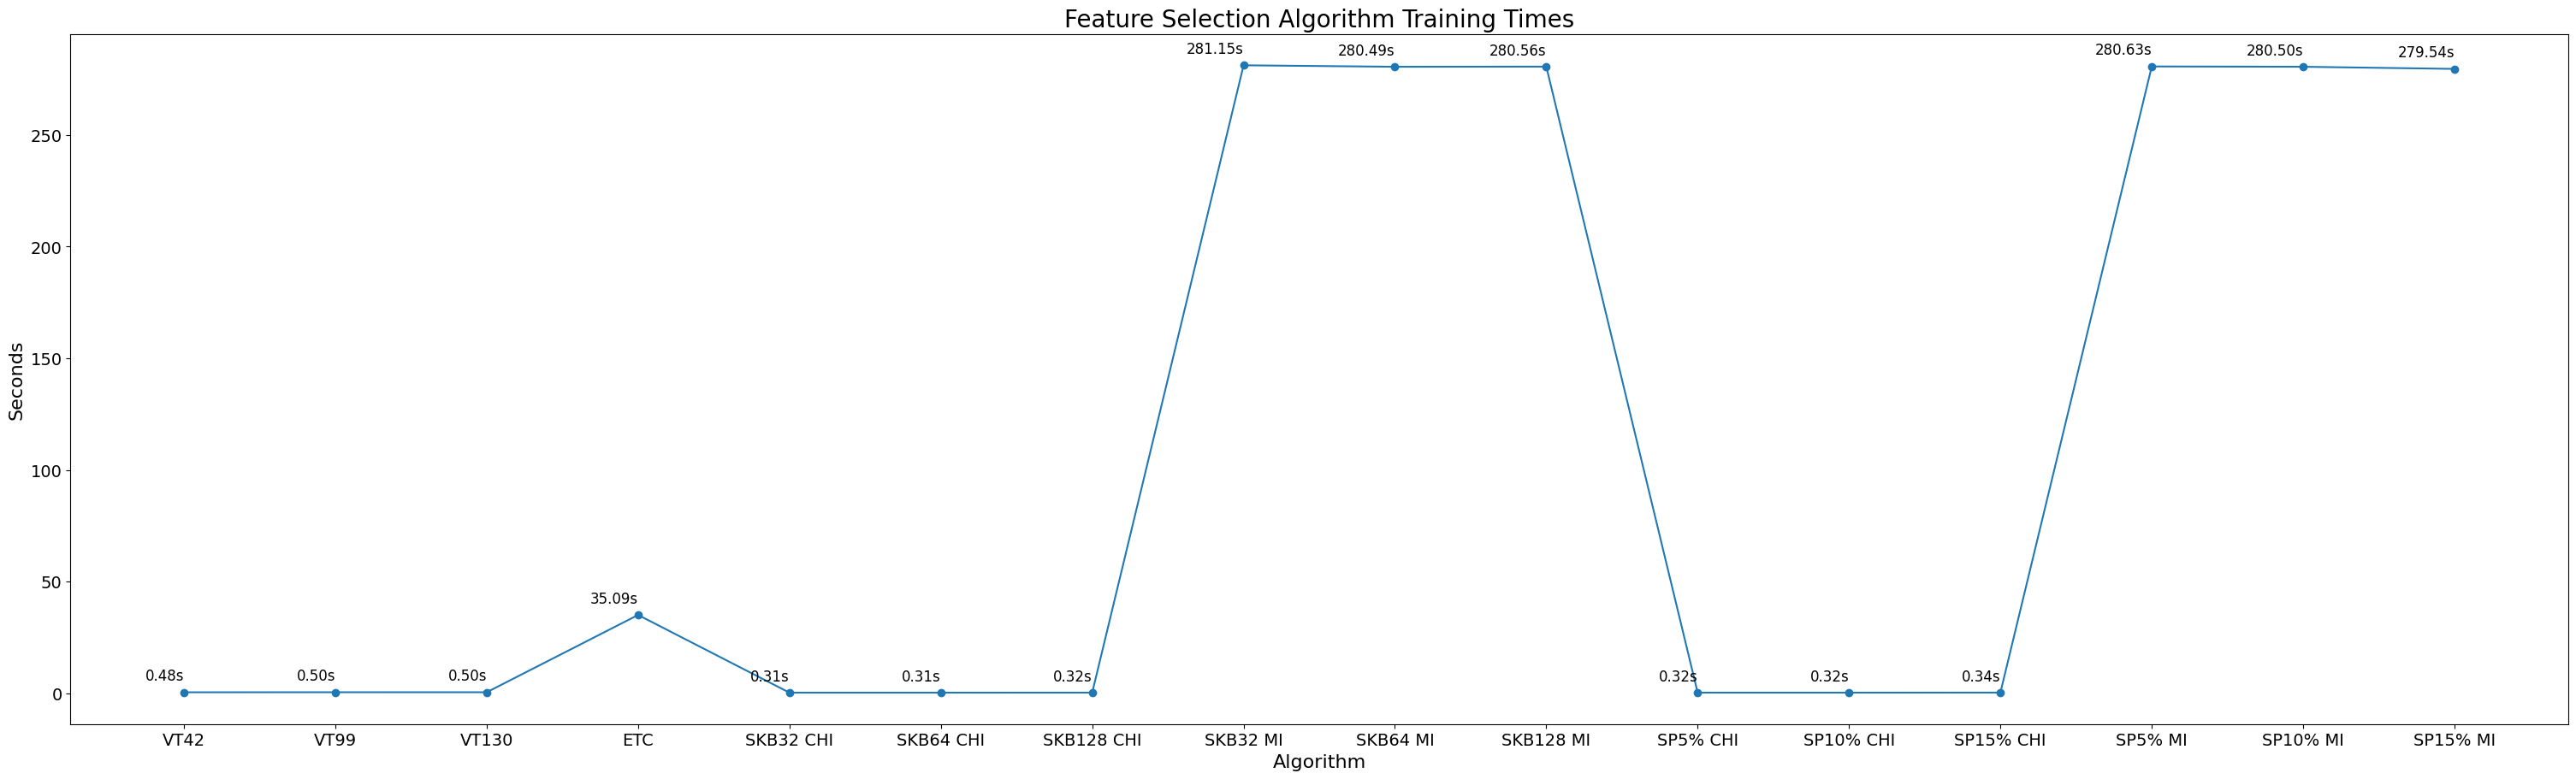

Time needed to train VT42 algorithm: 0.48 seconds.
Time needed to train VT99 algorithm: 0.50 seconds.
Time needed to train VT130 algorithm: 0.50 seconds.
Time needed to train ETC algorithm: 35.09 seconds.
Time needed to train SKB32 CHI algorithm: 0.31 seconds.
Time needed to train SKB64 CHI algorithm: 0.31 seconds.
Time needed to train SKB128 CHI algorithm: 0.32 seconds.
Time needed to train SKB32 MI algorithm: 281.15 seconds.
Time needed to train SKB64 MI algorithm: 280.49 seconds.
Time needed to train SKB128 MI algorithm: 280.56 seconds.
Time needed to train SP5% CHI algorithm: 0.32 seconds.
Time needed to train SP10% CHI algorithm: 0.32 seconds.
Time needed to train SP15% CHI algorithm: 0.34 seconds.
Time needed to train SP5% MI algorithm: 280.63 seconds.
Time needed to train SP10% MI algorithm: 280.50 seconds.
Time needed to train SP15% MI algorithm: 279.54 seconds.


In [160]:
keys = list(fs_train_times)
values = list(fs_train_times.values())
fig, ax = plt.subplots(figsize=(30, 9), layout='constrained')
plt.plot(keys, values, marker='o')
plt.xlabel('Algorithm', fontsize=16)
plt.ylabel('Seconds', fontsize=16)
plt.xticks(keys, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Feature Selection Algorithm Training Times', fontsize=20)

for i in range(len(keys)):
    plt.annotate(f'{values[i]:.2f}s', (keys[i], values[i]), textcoords="offset points", xytext=(0, 10), ha='right', fontsize=12)

plt.show()

for k, v in fs_train_times.items():
    print(f'Time needed to train {k} algorithm: {v:.2f} seconds.')

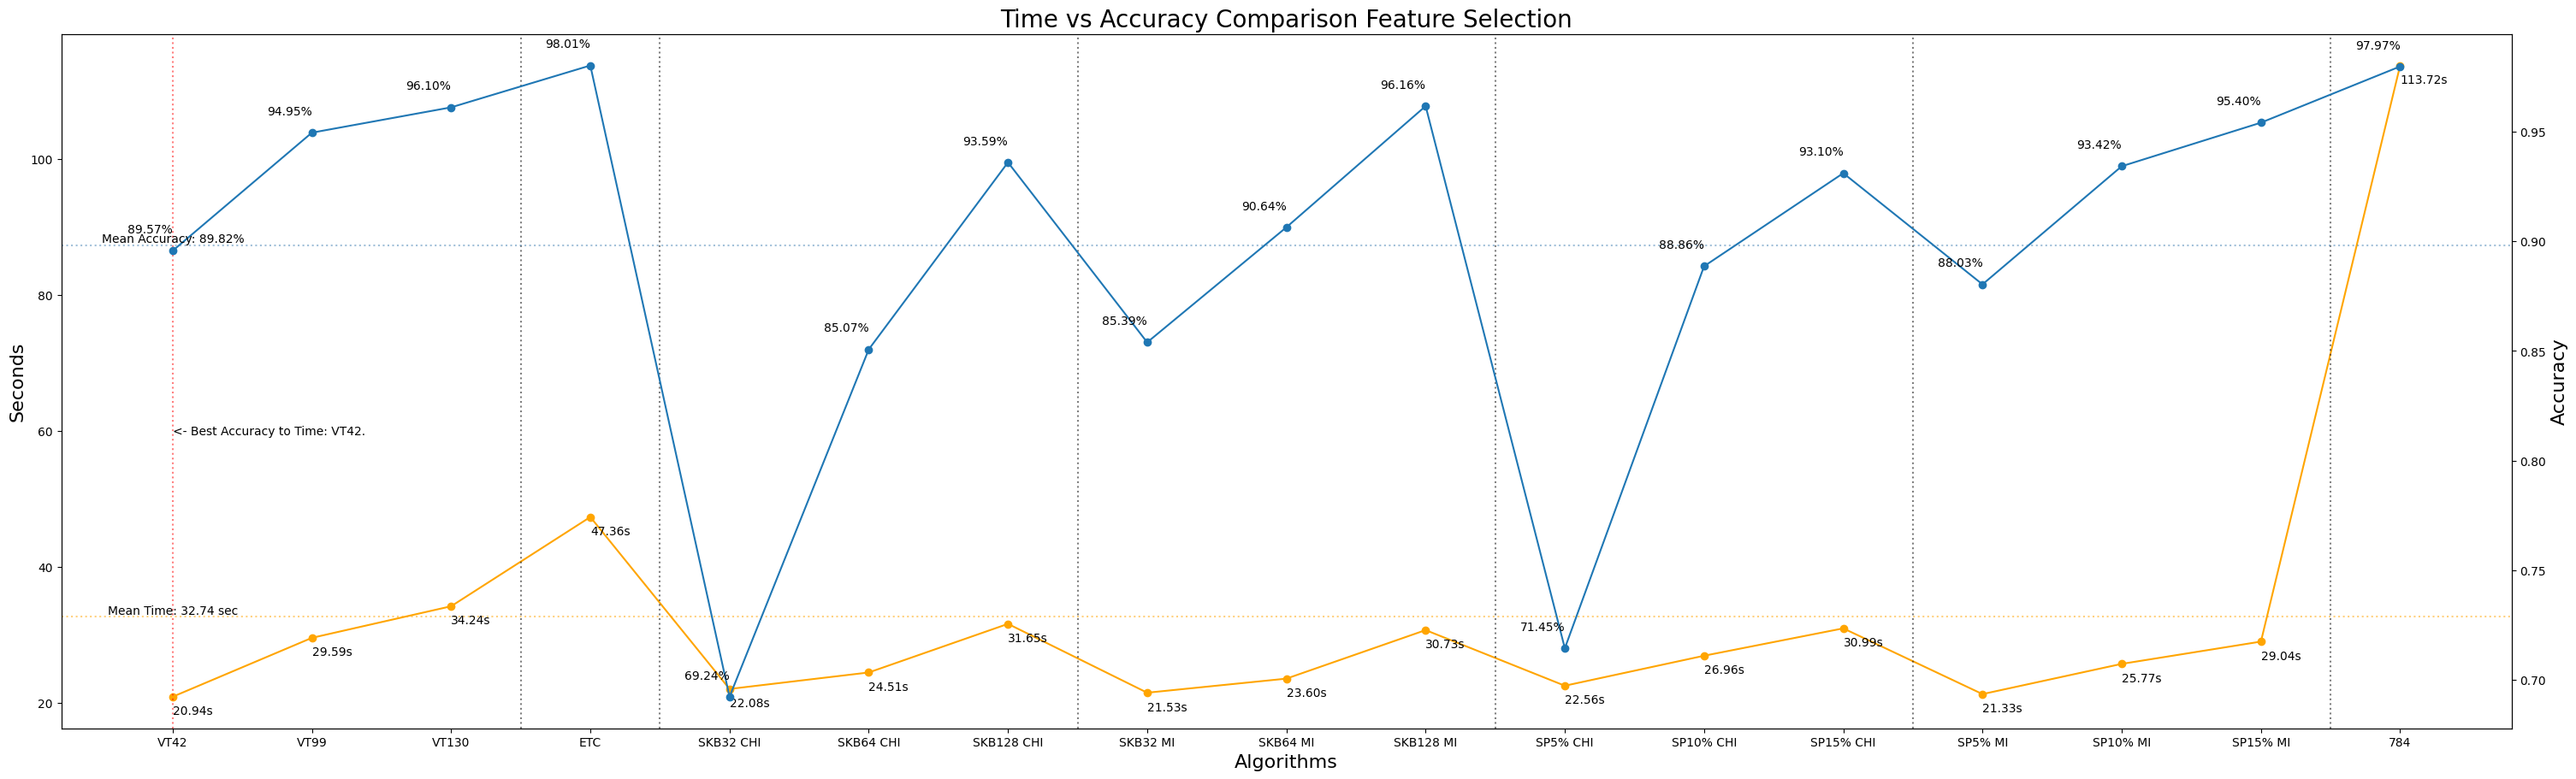

<<< Best accuracy compared to time is for VT42 algorithm. >>>


In [164]:
time_keys = list(fs_times)
time_values = list(fs_times.values())
time_keys.append('784')
time_values.append(base_time) 

acc_keys = list(fs_accs)
acc_values = list(fs_accs.values())
acc_keys.append('784')
acc_values.append(base_mnist)

mean_time = np.mean(time_values)
mean_acc = np.mean(acc_values)

fig, ax1 = plt.subplots(figsize=(30, 9), layout='constrained')
plt.title('Time vs Accuracy Comparison Feature Selection', fontsize=20)
ax1.plot(time_keys, time_values, marker='o', color='orange')
ax1.set_xlabel('Algorithms', fontsize=16)
ax1.set_ylabel('Seconds', fontsize=16)

ax2 = ax1.twinx()
ax2.plot(acc_keys, acc_values, marker='o')
ax2.set_ylabel('Accuracy', fontsize=16)

for i in range(len(time_keys)):
    ax1.annotate(f'{time_values[i]:.2f}s', (time_keys[i], time_values[i]), textcoords='offset points', xytext=(0, -15), ha='left')
    ax2.annotate(f'{acc_values[i]:.2%}', (acc_keys[i], acc_values[i]), textcoords='offset points', xytext=(0, 15), ha='right')

ax1.axhline(mean_time, color='orange', linestyle=':', label='Mean Time', alpha=0.5)
ax1.text(0, mean_time, f'Mean Time: {mean_time:.2f} sec', ha='center', va='bottom')
ax2.axhline(mean_acc, color='steelblue', linestyle=':', label='Mean Acc', alpha=0.5)
ax2.text(0, mean_acc, f'Mean Accuracy: {mean_acc:.2%}', ha='center', va='bottom')

worth = np.divide(acc_values, time_values)
best_alg = time_keys[np.argmax(worth)]

ax1.axvline(0, color='red', linestyle=':', label='Highest Value', alpha=0.5)
ax1.text(0, 60, f'<- Best Accuracy to Time: {best_alg}.', ha='left', va='center') 

ax1.axvline(2.5, color='black', linestyle=':', label='1', alpha=0.5)
ax1.axvline(3.5, color='black', linestyle=':', label='2', alpha=0.5)
ax1.axvline(6.5, color='black', linestyle=':', label='3', alpha=0.5)
ax1.axvline(9.5, color='black', linestyle=':', label='4', alpha=0.5)
ax1.axvline(12.5, color='black', linestyle=':', label='5', alpha=0.5)
ax1.axvline(15.5, color='black', linestyle=':', label='6', alpha=0.5)

plt.show()

print(f'<<< Best accuracy compared to time is for {best_alg} algorithm. >>>')

In [165]:
data = {
    'Training Time (s)': pd.Series(fs_train_times),
    'Accuracy (%)': pd.Series(fs_accs),
    'Test Time (s)': pd.Series(fs_times),
    'Total Time (s)': pd.Series({key: fs_train_times[key] + fs_times[key] for key in fs_train_times})
}

df = pd.DataFrame(data)

df['Training Time (s)'] = df['Training Time (s)'].map("{:.2f}".format)
df['Accuracy (%)'] = df['Accuracy (%)'].map("{:.2%}".format)
df['Test Time (s)'] = df['Test Time (s)'].map("{:.2f}".format)
df['Total Time (s)'] = df['Total Time (s)'].map("{:.2f}".format)

df

Training Time (s) Accuracy (%) Test Time (s) Total Time (s)
VT42                    0.48       89.57%         20.94          21.42
VT99                    0.50       94.95%         29.59          30.09
VT130                   0.50       96.10%         34.24          34.73
ETC                    35.09       98.01%         47.36          82.45
SKB32 CHI               0.31       69.24%         22.08          22.39
SKB64 CHI               0.31       85.07%         24.51          24.81
SKB128 CHI              0.32       93.59%         31.65          31.97
SKB32 MI              281.15       85.39%         21.53         302.69
SKB64 MI              280.49       90.64%         23.60         304.09
SKB128 MI             280.56       96.16%         30.73         311.29
SP5% CHI                0.32       71.45%         22.56          22.88
SP10% CHI               0.32       88.86%         26.96          27.28
SP15% CHI               0.34       93.10%         30.99          31.33
SP5% MI               280.63       88.03%         21.33         301.96
SP10% MI              280.50       93.42%         25.77         306.27
SP15% MI              279.54       95.40%         29.04         308.58